# ICLR Results

In [1]:
N_THREADS = 8
# Nota Bene : notebooks don't deallocate GPU memory
IS_FORCE_CPU = False # can also be set in the trainer

## Preparations

In [2]:
cd ..

/private/home/yannd/projects/Neural-Process-Family


In [3]:
%autosave 600
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# CENTER PLOTS
from IPython.core.display import HTML
display(HTML(""" <style> .output_png {display: table-cell; text-align: center; margin:auto; }
.prompt display:none;}  </style>"""))

import os
if IS_FORCE_CPU:
    os.environ['CUDA_VISIBLE_DEVICES'] = ""
    
import sys
sys.path.append("notebooks")

import numpy as np
import matplotlib.pyplot as plt
import torch
torch.set_num_threads(N_THREADS)

Autosaving every 600 seconds


## Dataset 

In [4]:
from utils.data import get_dataset
from utils.data.helpers import train_dev_split
from utils.visualize import plot_dataset_samples_imgs, plot_losses #, plot_posterior_samples_imgs

In [5]:
celeba32_train, celeba32_test = train_dev_split(get_dataset("celeba32")(), dev_size=0.1, is_stratify=False)
celeba64_train, celeba64_test = train_dev_split(get_dataset("celeba64")(), dev_size=0.1, is_stratify=False)
svhn_train, svhn_test = get_dataset("svhn")(split="train"), get_dataset("svhn")(split="test")
mnist_train, mnist_test = get_dataset("mnist")(split="train"), get_dataset("mnist")(split="test")
zs_mmnist_train, zs_mmnist_test = get_dataset("zs-multi-mnist")(split="train"), get_dataset("zs-multi-mnist")(split="test")

train_datasets_32 = {"mnist":mnist_train, "celeba32":celeba32_train}
test_datasets_32 = {"mnist":mnist_test, "celeba32":celeba32_test}
train_datasets_64 = {"zs-multi-mnist":zs_mmnist_train}
test_datasets_64 = {"zs-multi-mnist":zs_mmnist_test}


Using downloaded and verified file: /private/home/yannd/projects/Neural-Process-Family/utils/data/../../data/train_32x32.mat
Using downloaded and verified file: /private/home/yannd/projects/Neural-Process-Family/utils/data/../../data/test_32x32.mat


INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...
INFO:utils.data.imgs:Resizing ZeroShotMultiMNIST ...


In [6]:
from neuralproc.utils.datasplit import GridCntxtTrgtGetter, RandomMasker, no_masker, half_masker

# same as in previous tutorials but uses masks rather than indices
get_cntxt_trgt = GridCntxtTrgtGetter(context_masker=RandomMasker(min_nnz=0.01, max_nnz=0.5),
                                      target_masker=no_masker,
                                      is_add_cntxts_to_trgts=False)

In [7]:
from utils.visualize import plot_dataset_samples_imgs, plot_losses #, plot_posterior_samples_imgs

### Models

In [8]:
X_DIM = 2  # 2D spatial input 

In [9]:
from functools import partial
from neuralproc import RegularGridsConvolutionalProcess, AttentiveNeuralProcess, NeuralProcessLoss, ConvolutionalProcess
from neuralproc.predefined import UnetCNN, CNN, SelfAttention, MLP, ResConvBlock
from neuralproc import merge_flat_input

In [10]:
from train_imgs import get_model

# models that take into account the grid
models_grided_64 = {}
models_grided_64["GridedCCP"] = get_model("GridedCCP", img_shape=(64,64))
models_grided_64["GridedCCP_large"] = get_model("GridedCCP", 
                                                n_blocks=7, kernel_size=11, init_kernel_size=11, img_shape=(64,64))


models_grided_32 = {}
models_grided_32["GridedCCP"] = get_model("GridedCCP",  img_shape=(32,32))
models_grided_32["GridedCCP_large"] = get_model("GridedCCP", n_blocks=7, kernel_size=11, init_kernel_size=11, img_shape=(32, 32))

models_general = {}
models_general["SelfAttnCNP"] = get_model("SelfAttnCNP")

In [11]:
def add_y_dim(models, datasets):
    """Add y _dim to all ofthe models depending on the dataset."""
    return {data_name: {model_name: partial(model, y_dim=data_train.shape[0]) 
                        for model_name, model in models.items()} 
            for data_name, data_train in datasets.items()}

### Loading Pretrained

In [12]:
def merge_dicts(dicts):
    out = dict()
    for d in dicts:
        out.update(d)
    return out

In [13]:
from neuralproc import NeuralProcessLoss
from utils.train import train_models
from utils.data import cntxt_trgt_collate
import skorch

import os
import contextlib

kwargs = dict(chckpnt_dirname="results/iclr/", 
             is_retrain=False, 
             train_split=skorch.dataset.CVSplit(0.1), # use 10% of data for validation 
             patience=10,
             batch_size=16,
             seed=123,
             runs=1)

# Takes 1-3 mins
with open(os.devnull, "w") as f, contextlib.redirect_stdout(f): # don't print

    trainers_grided_64 = train_models(train_datasets_64, 
                                     add_y_dim(models_grided_64, train_datasets_64),
                                      NeuralProcessLoss,
                                      iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                               is_return_masks=True), 
                                     iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                               is_return_masks=True),
                                     **kwargs) 

    trainers_grided_32 = train_models(train_datasets_32, 
                                     add_y_dim(models_grided_32, train_datasets_32),
                                      NeuralProcessLoss,
                                      iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                               is_return_masks=True), 
                                     iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt, 
                                                               is_return_masks=True),
                                     **kwargs) 

    train_datasets_all = merge_dicts([train_datasets_32, train_datasets_64])

    trainers_general = train_models(train_datasets_all, 
                                     add_y_dim(models_general, train_datasets_all),
                                     NeuralProcessLoss,
                                     iterator_train__collate_fn=cntxt_trgt_collate(get_cntxt_trgt), 
                                     iterator_valid__collate_fn=cntxt_trgt_collate(get_cntxt_trgt),
                                     **kwargs) 

/private/home/yannd/projects/Neural-Process-Family/neuralproc/predefined/mlp.py:67: UserWarning: hidden_size=32 smaller than output=128 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))
/private/home/yannd/projects/Neural-Process-Family/neuralproc/predefined/mlp.py:67: UserWarning: hidden_size=32 smaller than output=256 and input=128. Setting it to 128.
  warnings.warn(txt.format(hidden_size, output_size, input_size, self.hidden_size))


## Qualitative

In [14]:
from neuralproc.utils.predict import AutoregressivePredictor, VanillaPredictor
from utils.helpers import set_seed
from utils.visualize import plot_posterior_img, plot_qualitative_with_kde
from utils.visualize.visualize_imgs import DFLT_FIGSIZE, points_to_grid

### Comparing GridedCCP and SelfAttnCNP

In [18]:
import random
import os

import matplotlib.pyplot as plt
import torch
from torchvision.utils import make_grid
import numpy as np
from skorch.dataset import unpack_data
import seaborn as sns
import matplotlib.ticker as ticker
from skorch.dataset import unpack_data, uses_placeholder_y

from neuralproc.utils.helpers import prod, channels_to_2nd_dim
from neuralproc.utils.predict import VanillaPredictor
from utils.data import cntxt_trgt_collate
from utils.helpers import set_seed, tuple_cont_to_cont_tuple
from utils.train import EVAL_FILENAME
from utils.evaluate import eval_loglike

def remove_axis(ax, is_rm_ticks=True, is_rm_spines=True):
    """Remove all axis but not the labels."""
    if is_rm_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        
    if is_rm_ticks:
        ax.tick_params(bottom="off", left="off")
        
        
def plot_dataset_samples_imgs(
    dataset, n_plots=4, figsize=DFLT_FIGSIZE, ax=None, pad_value=1, seed=123
):
    """Plot `n_samples` samples of the a datset."""
    set_seed(seed)

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    img_tensor = torch.stack(
        [dataset[random.randint(0, len(dataset) - 1)][0] for i in range(n_plots)], dim=0
    )
    grid = make_grid(img_tensor, nrow=2, pad_value=pad_value)

    ax.imshow(grid.permute(1, 2, 0).numpy())
    ax.axis("off")

from neuralproc.utils.helpers import prod, channels_to_2nd_dim
from neuralproc.utils.predict import VanillaPredictor
from utils.data import cntxt_trgt_collate
from utils.helpers import set_seed, tuple_cont_to_cont_tuple
from utils.train import EVAL_FILENAME

def plot_posterior_img(
    data,
    get_cntxt_trgt,
    model,
    MeanPredictor=VanillaPredictor,
    is_uniform_grid=True,
    img_indcs=None,
    n_plots=4,
    figsize=(18, 4),
    ax=None,
    seed=123,
    is_return=False,
):  # TO DOC
    """
    Plot the mean of the estimated posterior for images.

    Parameters
    ----------
    data : Dataset
        Dataset from which to sample the images.

    get_cntxt_trgt : callable or dict
        Function that takes as input the features and tagrets `X`, `y` and return
        the corresponding `X_cntxt, Y_cntxt, X_trgt, Y_trgt`. If dict should contain the correct 
        `X_cntxt, Y_cntxt, X_trgt, Y_trgt`.

    model : nn.Module
        Model used to initialize `MeanPredictor`.

    MeanPredictor : untitialized callable, optional
        Callable which is initalized with `MeanPredictor(model)` and then takes as
        input `X_cntxt, Y_cntxt, X_trgt` (`mask_cntxt, X, mask_trgt` if
        `is_uniform_grid`) and returns the mean the posterior. E.g. `VanillaPredictor`
        or `AutoregressivePredictor`.

    is_uniform_grid : bool, optional
        Whether the input are the image and corresponding masks rather than
        the slected pixels. Typically used for `RegularGridsConvolutionalProcess`.

    img_indcs : list of int, optional
        Indices of the images to plot. If `None` will randomly sample `n_plots`
        of them.

    n_plots : int, optional
        Number of images to samples. They will be plotted in different columns.
        Only used if `img_indcs` is `None`.

    figsize : tuple, optional

    ax : plt.axes.Axes, optional

    seed : int, optional
    """
    set_seed(seed)

    model.eval()

    dim_grid = 2 if is_uniform_grid else 1
    if isinstance(get_cntxt_trgt, dict):
        mask_cntxt = get_cntxt_trgt["X_cntxt"]
        X = get_cntxt_trgt["Y_cntxt"]
        mask_trgt = get_cntxt_trgt["X_trgt"]
        n_plots = mask_cntxt.size(0)

    else:
        if img_indcs is None:
            img_indcs = [random.randint(0, len(data)) for _ in range(n_plots)]
        n_plots = len(img_indcs)
        imgs = [data[i] for i in img_indcs]

        cntxt_trgt = cntxt_trgt_collate(get_cntxt_trgt, is_return_masks=is_uniform_grid)(imgs)[0]
        mask_cntxt, X, mask_trgt, _ = (
            cntxt_trgt["X_cntxt"],
            cntxt_trgt["Y_cntxt"],
            cntxt_trgt["X_trgt"],
            cntxt_trgt["Y_trgt"],
        )

    mean_y = MeanPredictor(model)(mask_cntxt, X, mask_trgt)

    if is_uniform_grid:
        mean_y = mean_y.view(*X.shape)

    if X.shape[-1] == 1:
        X = X.expand(-1, *[-1] * dim_grid, 3)
        mean_y = mean_y.expand(-1, *[-1] * dim_grid, 3)

    if is_uniform_grid:
        background = (
            data.missing_px_color.view(1, *[1] * dim_grid, 3).expand(*mean_y.shape).clone()
        )
        out_cntxt = torch.where(mask_cntxt, X, background)

        background[mask_trgt.squeeze(-1)] = mean_y.view(-1, 3)
        out_pred = background.clone()

    else:
        out_cntxt, _ = points_to_grid(
            mask_cntxt, X, data.shape[1:], background=data.missing_px_color
        )

        out_pred, _ = points_to_grid(
            mask_trgt, mean_y, data.shape[1:], background=data.missing_px_color
        )

    outs = [out_cntxt, out_pred]

    grid = make_grid(channels_to_2nd_dim(torch.cat(outs, dim=0)), nrow=n_plots, pad_value=1.0)

    if is_return:
        return grid

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    ax.imshow(grid.permute(1, 2, 0).numpy())
    ax.axis("off")
    
    
    
# TO CLEAN
def plot_qualitative_with_kde(
    named_trainer,
    dataset,
    named_trainer_compare=None,
    n_images=8,
    percentiles=None, # if None uses uniform linspace from n_images
    figsize=DFLT_FIGSIZE,
    title=None,
    seed=123,
    height_ratios=[1,3],
    font_size=12,
    h_pad=-3,
    **kwargs
):
    """
    Plot qualitative samples using `plot_posterior_img` but select the samples and mask to plot
    given the score at test time.
    
    VERY DIRTY
    """
    if percentiles is not None:
        n_images = len(percentiles)
    
    plt.rcParams.update({'font.size': font_size})
    fig, axes = plt.subplots(2, 1, figsize=figsize, gridspec_kw={'height_ratios': height_ratios})

    def _plot_kde_loglike(name, trainer):
        chckpnt_dirname = dict(trainer.callbacks_)["Checkpoint"].dirname
        test_eval_file = os.path.join(chckpnt_dirname, EVAL_FILENAME)
        test_loglike = np.loadtxt(test_eval_file, delimiter=",")
        sns.kdeplot(test_loglike, ax=axes[0], shade=True, label=name, cut=0)
        sns.despine()
        return test_loglike
    
    def _grid_to_points(selected_data):
        for i in range(n_images):
            X = selected_data["Y_cntxt"][i]
            X_cntxt, Y_cntxt = GridCntxtTrgtGetter.select(None, X, None, selected_data["X_cntxt"][i])
            X_trgt, Y_trgt = GridCntxtTrgtGetter.select(None, X, None, selected_data["X_trgt"][i])
            yield dict(X_cntxt=X_cntxt, Y_cntxt=Y_cntxt, X_trgt=X_trgt, Y_trgt=Y_trgt)
    
    def _plot_posterior_img_selected(name, trainer, selected_data, is_grided_data):
        is_uniform_grid="grided" in name.lower()  # use a better way
        
        kwargs["img_indcs"]=[]
        kwargs["is_uniform_grid"]=is_uniform_grid
        kwargs["is_return"]=True
        
        if not is_uniform_grid:
            if is_grided_data:
                grids = [plot_posterior_img(dataset, data, trainer.module_.cpu(), **kwargs)
                         for i, data in enumerate(_grid_to_points(selected_data))]
            else:
                grids = [plot_posterior_img(dataset, {k:v[i] for k,v in selected_data.items()}, 
                                            trainer.module_.cpu(), **kwargs)
                         for i in range(n_images)]
                
            # images are padded by 2 pixels inbetween each but here you concatenate => will pad twice
            # => remove all the rleft padding for each besides first
            grids = [g[...,2:] if i != 0 else g
                     for i, g in enumerate(grids)]
            return torch.cat(grids, axis=-1)
        
        elif is_uniform_grid:   
            if not is_grided_data:
                grids = []
                for i in range(n_images):
                
                    _, X_cntxt = points_to_grid(selected_data["X_cntxt"][i], selected_data["Y_cntxt"][i], 
                                   dataset.shape[1:], background=torch.tensor([0.0]*dataset.shape[0]))
                    Y_trgt, X_trgt = points_to_grid(selected_data["X_trgt"][i], selected_data["Y_trgt"][i], 
                                   dataset.shape[1:],background=torch.tensor([0.0]*dataset.shape[0]))
                    
                    grids.append(plot_posterior_img(dataset, 
                                                    dict(X_cntxt=X_cntxt, 
                                                                Y_cntxt=Y_trgt, # Y_trgt is all X because no masking for target (assumption)
                                                                X_trgt=X_trgt,
                                                                Y_trgt=Y_trgt),
                                                    trainer.module_.cpu(), 
                                                    **kwargs))
                    
                grids = [g[...,2:] if i != 0 else g for i, g in enumerate(grids)]


                return torch.cat(grids, axis=-1)
            else:
                print(selected_data["X_cntxt"][0].device)
                return plot_posterior_img(
                            dataset,
                            {k: torch.cat(v, dim=0) for k, v in selected_data.items()},
                            trainer.module_.cpu(),
                            **kwargs)
        
    name, trainer = named_trainer
    test_loglike = _plot_kde_loglike(name, trainer)
    
    if named_trainer_compare is not None:
        left = axes[0].get_xlim()[0]
        _ = _plot_kde_loglike(*named_trainer_compare)
        axes[0].set_xlim(left=left) # left bound by first model to not look strange

    if percentiles is not None:
        idcs = []
        values = []
        for i, p in enumerate(percentiles):
            # value closest to percentile
            percentile_val = np.percentile(test_loglike, p, interpolation='nearest')
            idcs.append(np.argwhere(test_loglike == percentile_val).item())
            values.append(percentile_val)
        #sorted_idcs = list(np.sort(idcs))[::-1]
    else:
        # find indices such that same space between all
        values = np.linspace(test_loglike.min(), test_loglike.max(), n_images)
        idcs = [(np.abs(test_loglike - v)).argmin() for v in values]
        #sorted_idcs = list(np.sort(idcs))[::-1]
        
    selected_data = [None]*n_images
    selected_indcs = [None]*n_images
    selected_values = [float("inf")]*n_images

    print(values)
    
    set_seed(seed)  # make sure same order and indices for cntxt and trgt
    trainer.notify("on_epoch_begin", dataset_valid=dataset)
    i = 0
    
    #queue = sorted_idcs.copy()
    #next_idx = queue.pop()
    trainer.module_.to(trainer.device)
    trainer.criterion_.is_return_all = True
    y_valid_is_ph = uses_placeholder_y(dataset)
        
    for data in trainer.get_iterator(dataset, training=False):
        Xi, yi = unpack_data(data)
        yi_res = yi if not y_valid_is_ph else None
        trainer.notify("on_batch_begin", X=Xi, y=yi_res, training=False)
        step = trainer.validation_step(Xi, yi, **kwargs)
        trainer.notify('on_batch_end', X=Xi, y=yi_res, training=False, **step)
        
        for cur_idx in range(yi.size(0)):
            
            #if next_idx != i:
            #continue
                
            for j,v in enumerate(values):
                if abs(-step["loss"][cur_idx] - v) < abs(selected_values[j] - v):
                    # if closer than before
                    selected_values[j] = -step["loss"][cur_idx]
                    selected_data[j] = {k: v[cur_idx : cur_idx + 1, ...] for k, v in Xi.items()}
                    selected_indcs[j] = i
            
            """
            if len(queue) == 0:
                break
            else:
                next_idx = queue.pop()
            """
            
            i += 1
                
    trainer.criterion_.is_return_all = False
            
    selected_data = {
        k: v for k, v in tuple_cont_to_cont_tuple(selected_data).items()
    }
    
    for v in values:
        axes[0].axvline(v, linestyle=":",
                    alpha=0.3,
                    c="tab:green")
        
    axes[0].legend(loc="upper left")
    
    if title is not None:
        axes[0].set_title(title, fontsize=18)

    is_grided_data = "grided" in name.lower()
    grid = _plot_posterior_img_selected(name, trainer, selected_data, is_grided_data)
    
    middle_img = test_data.shape[1]//2+1
    y_ticks = [middle_img, middle_img*3]
    y_ticks_labels = ["Context", name]
    
    if named_trainer_compare is not None:
        grid_compare = _plot_posterior_img_selected(*named_trainer_compare, selected_data, is_grided_data)          
        grid = torch.cat((grid, grid_compare[:, grid_compare.size(1)//2+1:, :]), dim=1)
        
        y_ticks += [middle_img*5] 
        y_ticks_labels += [named_trainer_compare[0]] 

    axes[1].imshow(grid.permute(1, 2, 0).numpy())

    axes[1].yaxis.set_major_locator(ticker.FixedLocator(y_ticks))
    axes[1].set_yticklabels(y_ticks_labels, rotation='vertical', va="center")
    
    remove_axis(axes[1])
    
    if percentiles is not None:
        axes[1].xaxis.set_major_locator(ticker.FixedLocator([(test_data.shape[2]//2+1) * (i*2+1)
                                                             for i, p in enumerate(percentiles)]))
        axes[1].set_xticklabels(["{}%".format(p) for p in percentiles])
    else:
        axes[1].set_xticks([]) 
    
    

    
    fig.tight_layout(h_pad=h_pad)
    # ----------------------------------------

In [19]:
data_name = "mnist"
test_data = mnist_test

[-0.5859005451202393, 0.5749161243438721, 0.8639482855796814, 1.037177324295044, 1.228233814239502, 1.2936522960662842, 1.339428424835205, 1.358783483505249, 1.3822202682495117]


cpu


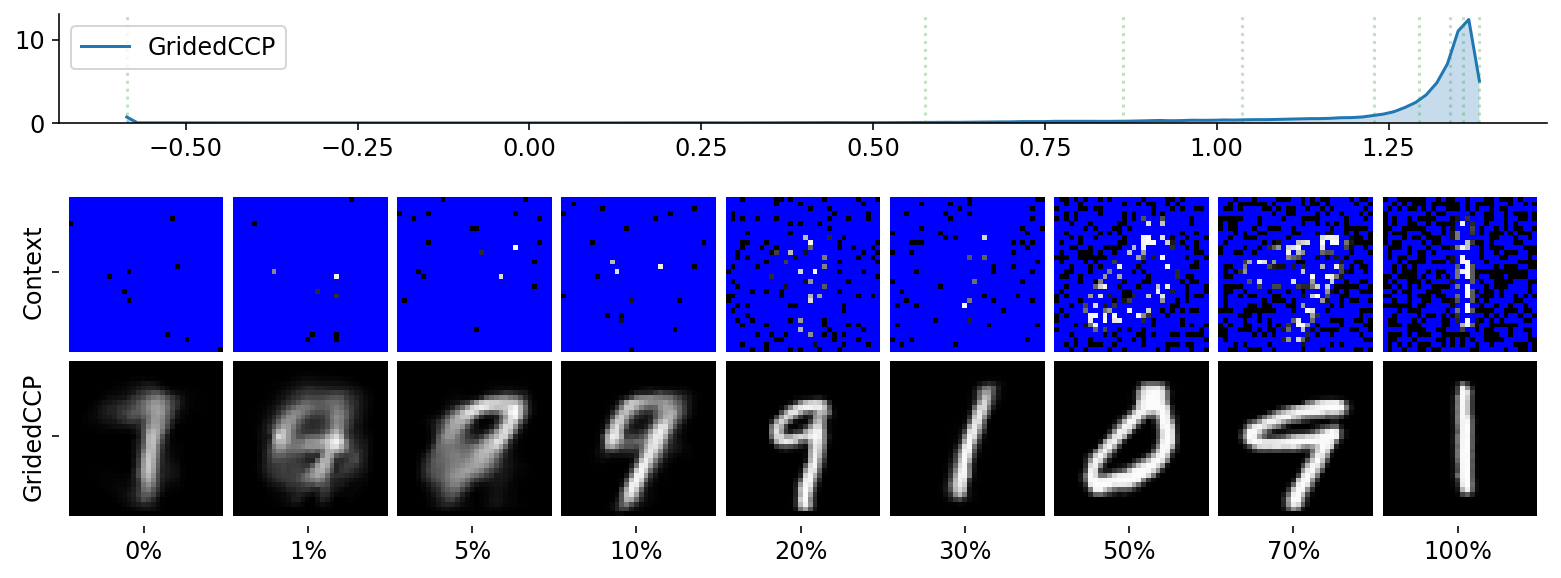

In [20]:
test_loglike = plot_qualitative_with_kde(["GridedCCP", trainers_grided_32['{}/GridedCCP_large/run_0'.format(data_name)]],
                                         test_data,
                                         figsize=(11, 5),
                                         percentiles=[0, 1,5,10,20,30,50,70,100],
                                        height_ratios=[1,6],
                                        h_pad=-2.5)

[-0.03258124  0.16890193  0.3703851   0.57186827  0.77335144  0.9748346
  1.17631777  1.37780094]


tensor(0.0116, device='cuda:0')
tensor(0.0688, device='cuda:0')
[tensor(0.0116, device='cuda:0'), tensor(0.0688, device='cuda:0'), tensor(0.0688, device='cuda:0'), tensor(0.0688, device='cuda:0'), tensor(0.0688, device='cuda:0'), tensor(0.0688, device='cuda:0'), tensor(0.0688, device='cuda:0'), tensor(0.0688, device='cuda:0')]


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same

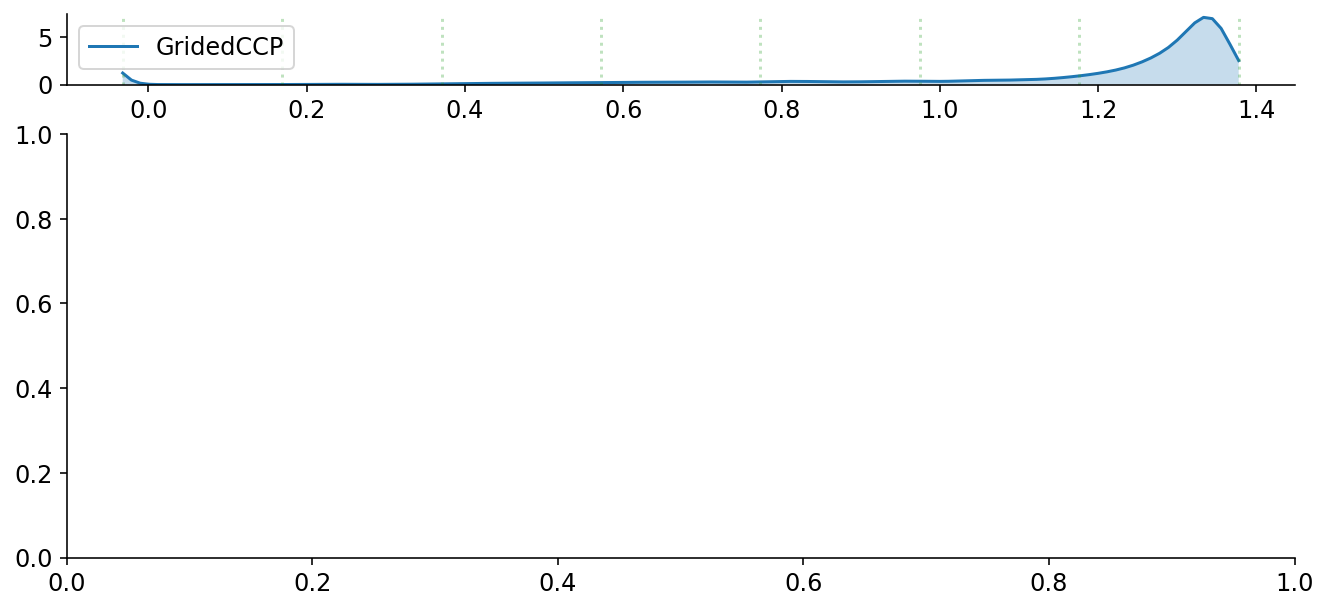

In [18]:
data_name = "mnist"
test_data = mnist_test

test_loglike = plot_qualitative_with_kde(["GridedCCP", trainers_grided_32['{}/GridedCCP/run_0'.format(data_name)]],
                                         test_data,
                                         figsize=(11, 5),
                                         n_images=8,
                                        height_ratios=[1,6],
                                        h_pad=-2.5)

[-3.2754037380218506, -2.235970973968506, -1.7292401790618896, -1.4653820991516113, -1.1750603914260864, -0.9755522012710571, -0.6769080758094788, -0.40121057629585266, 0.7883613705635071]


RuntimeError: CUDA out of memory. Tried to allocate 3.38 GiB (GPU 0; 15.90 GiB total capacity; 6.94 GiB already allocated; 2.45 GiB free; 2.55 GiB cached)

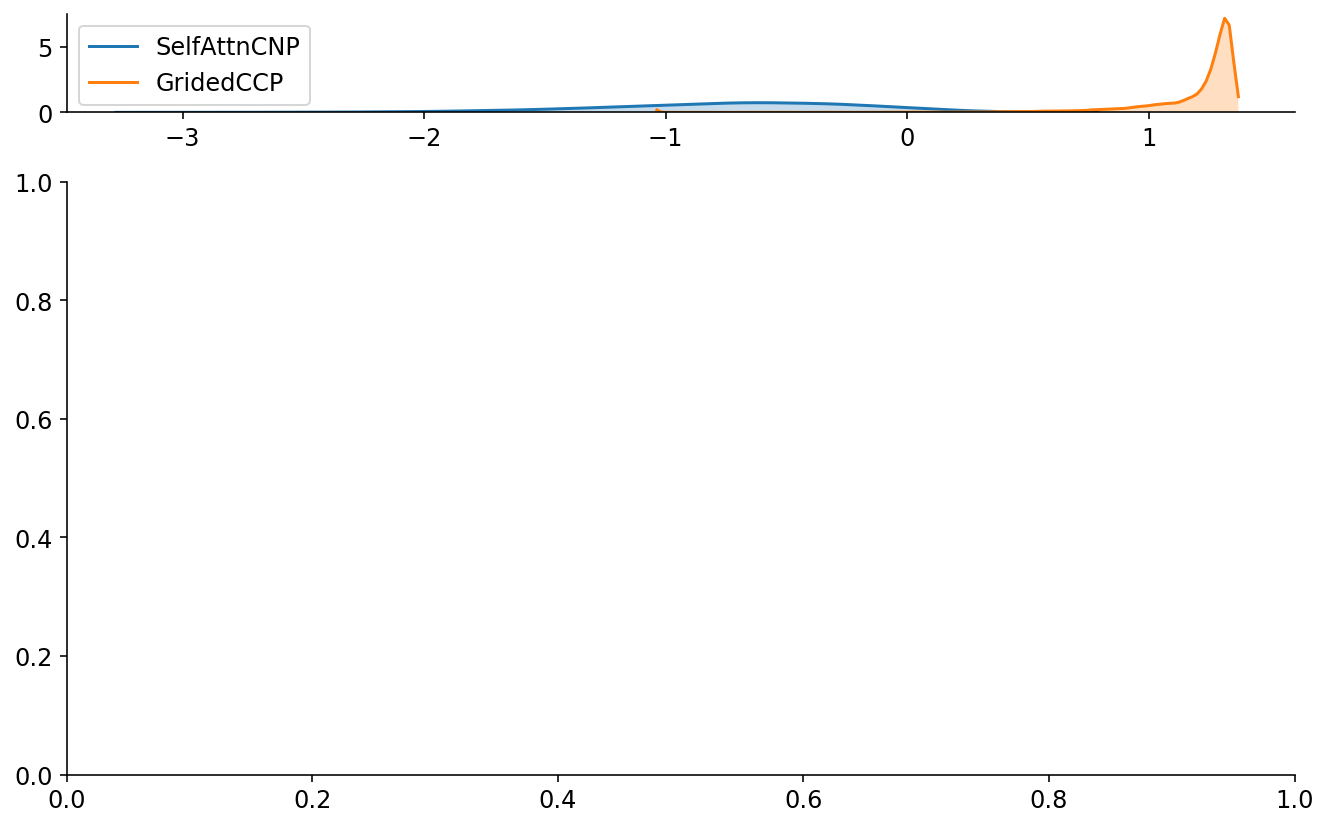

In [21]:
data_name = "zs-multi-mnist"
test_data = zs_mmnist_test


test_loglike = plot_qualitative_with_kde(["SelfAttnCNP", trainers_general['{}/SelfAttnCNP/run_0'.format(data_name)]],
                                         test_data,
                                         named_trainer_compare=["GridedCCP", trainers_grided_64['{}/GridedCCP/run_0'.format(data_name)]],
                                         figsize=(11, 7),
                                         percentiles=[0, 1,5,10,20,30,50,70,100],
                                         height_ratios=[1,6],
                                         h_pad=-5)


test_loglike = plot_qualitative_with_kde(["GridedCCP", trainers_grided_64['{}/GridedCCP/run_0'.format(data_name)]],
                                         test_data,
                                         named_trainer_compare=["SelfAttnCNP", trainers_general['{}/SelfAttnCNP/run_0'.format(data_name)]],
                                         figsize=(11, 7),
                                         percentiles=[0, 1,5,10,20,30,50,70,100],
                                        height_ratios=[1,6],
                                         h_pad=-5)

In [ ]:
data_name = "celeba32"
test_data = celeba32_test

test_loglike = plot_qualitative_with_kde(["GridedCCP_large", trainers_grided_32['{}/GridedCCP_large/run_0'.format(data_name)]],
                                         test_data,
                                         named_trainer_compare=["SelfAttnCNP", trainers_general['{}/SelfAttnCNP/run_0'.format(data_name)]],
                                         figsize=(11, 7),
                                         percentiles=[0, 1,5,10,20,30,50,70,100],
                                         title=data_name,
                                        height_ratios=[1,6],
                                         h_pad=-3)



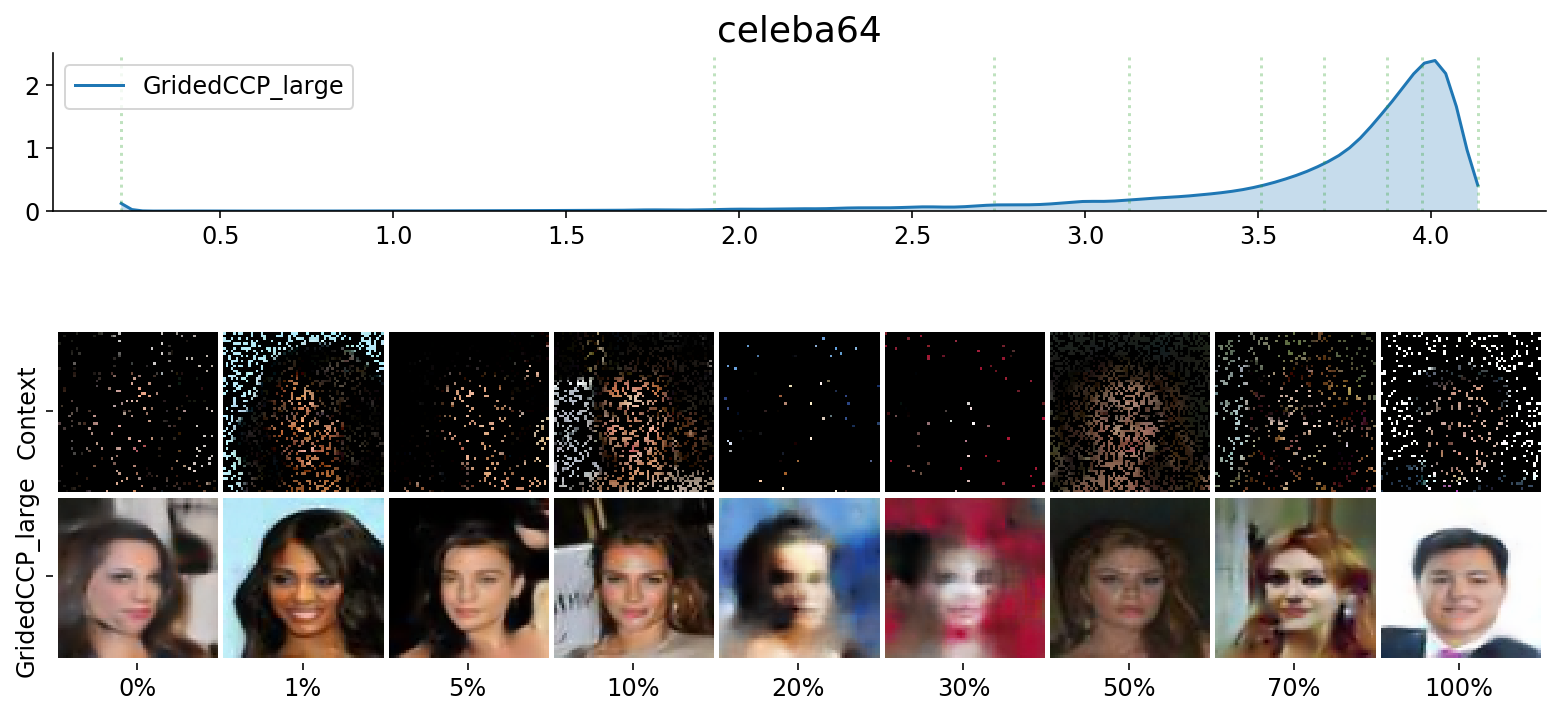

In [76]:
data_name = "celeba64"
test_data = celeba64_test

test_loglike = plot_qualitative_with_kde(["GridedCCP_large", trainers_grided_64['{}/GridedCCP_large/run_0'.format(data_name)]],
                                         test_data,
                                         figsize=(11, 7),
                                         percentiles=[0, 1,5,10,20,30,50,70,100],
                                         title=data_name,
                                        height_ratios=[1,6],
                                         h_pad=-3)

### The Need for Translation Equivariance

TO-DO: 
- Test the Grided CCP on real image

# Appendix

In [36]:
trainers_grided = merge_dicts([trainers_grided_64, trainers_grided_32, trainers_general])

## Qualitative Results under Different Settings

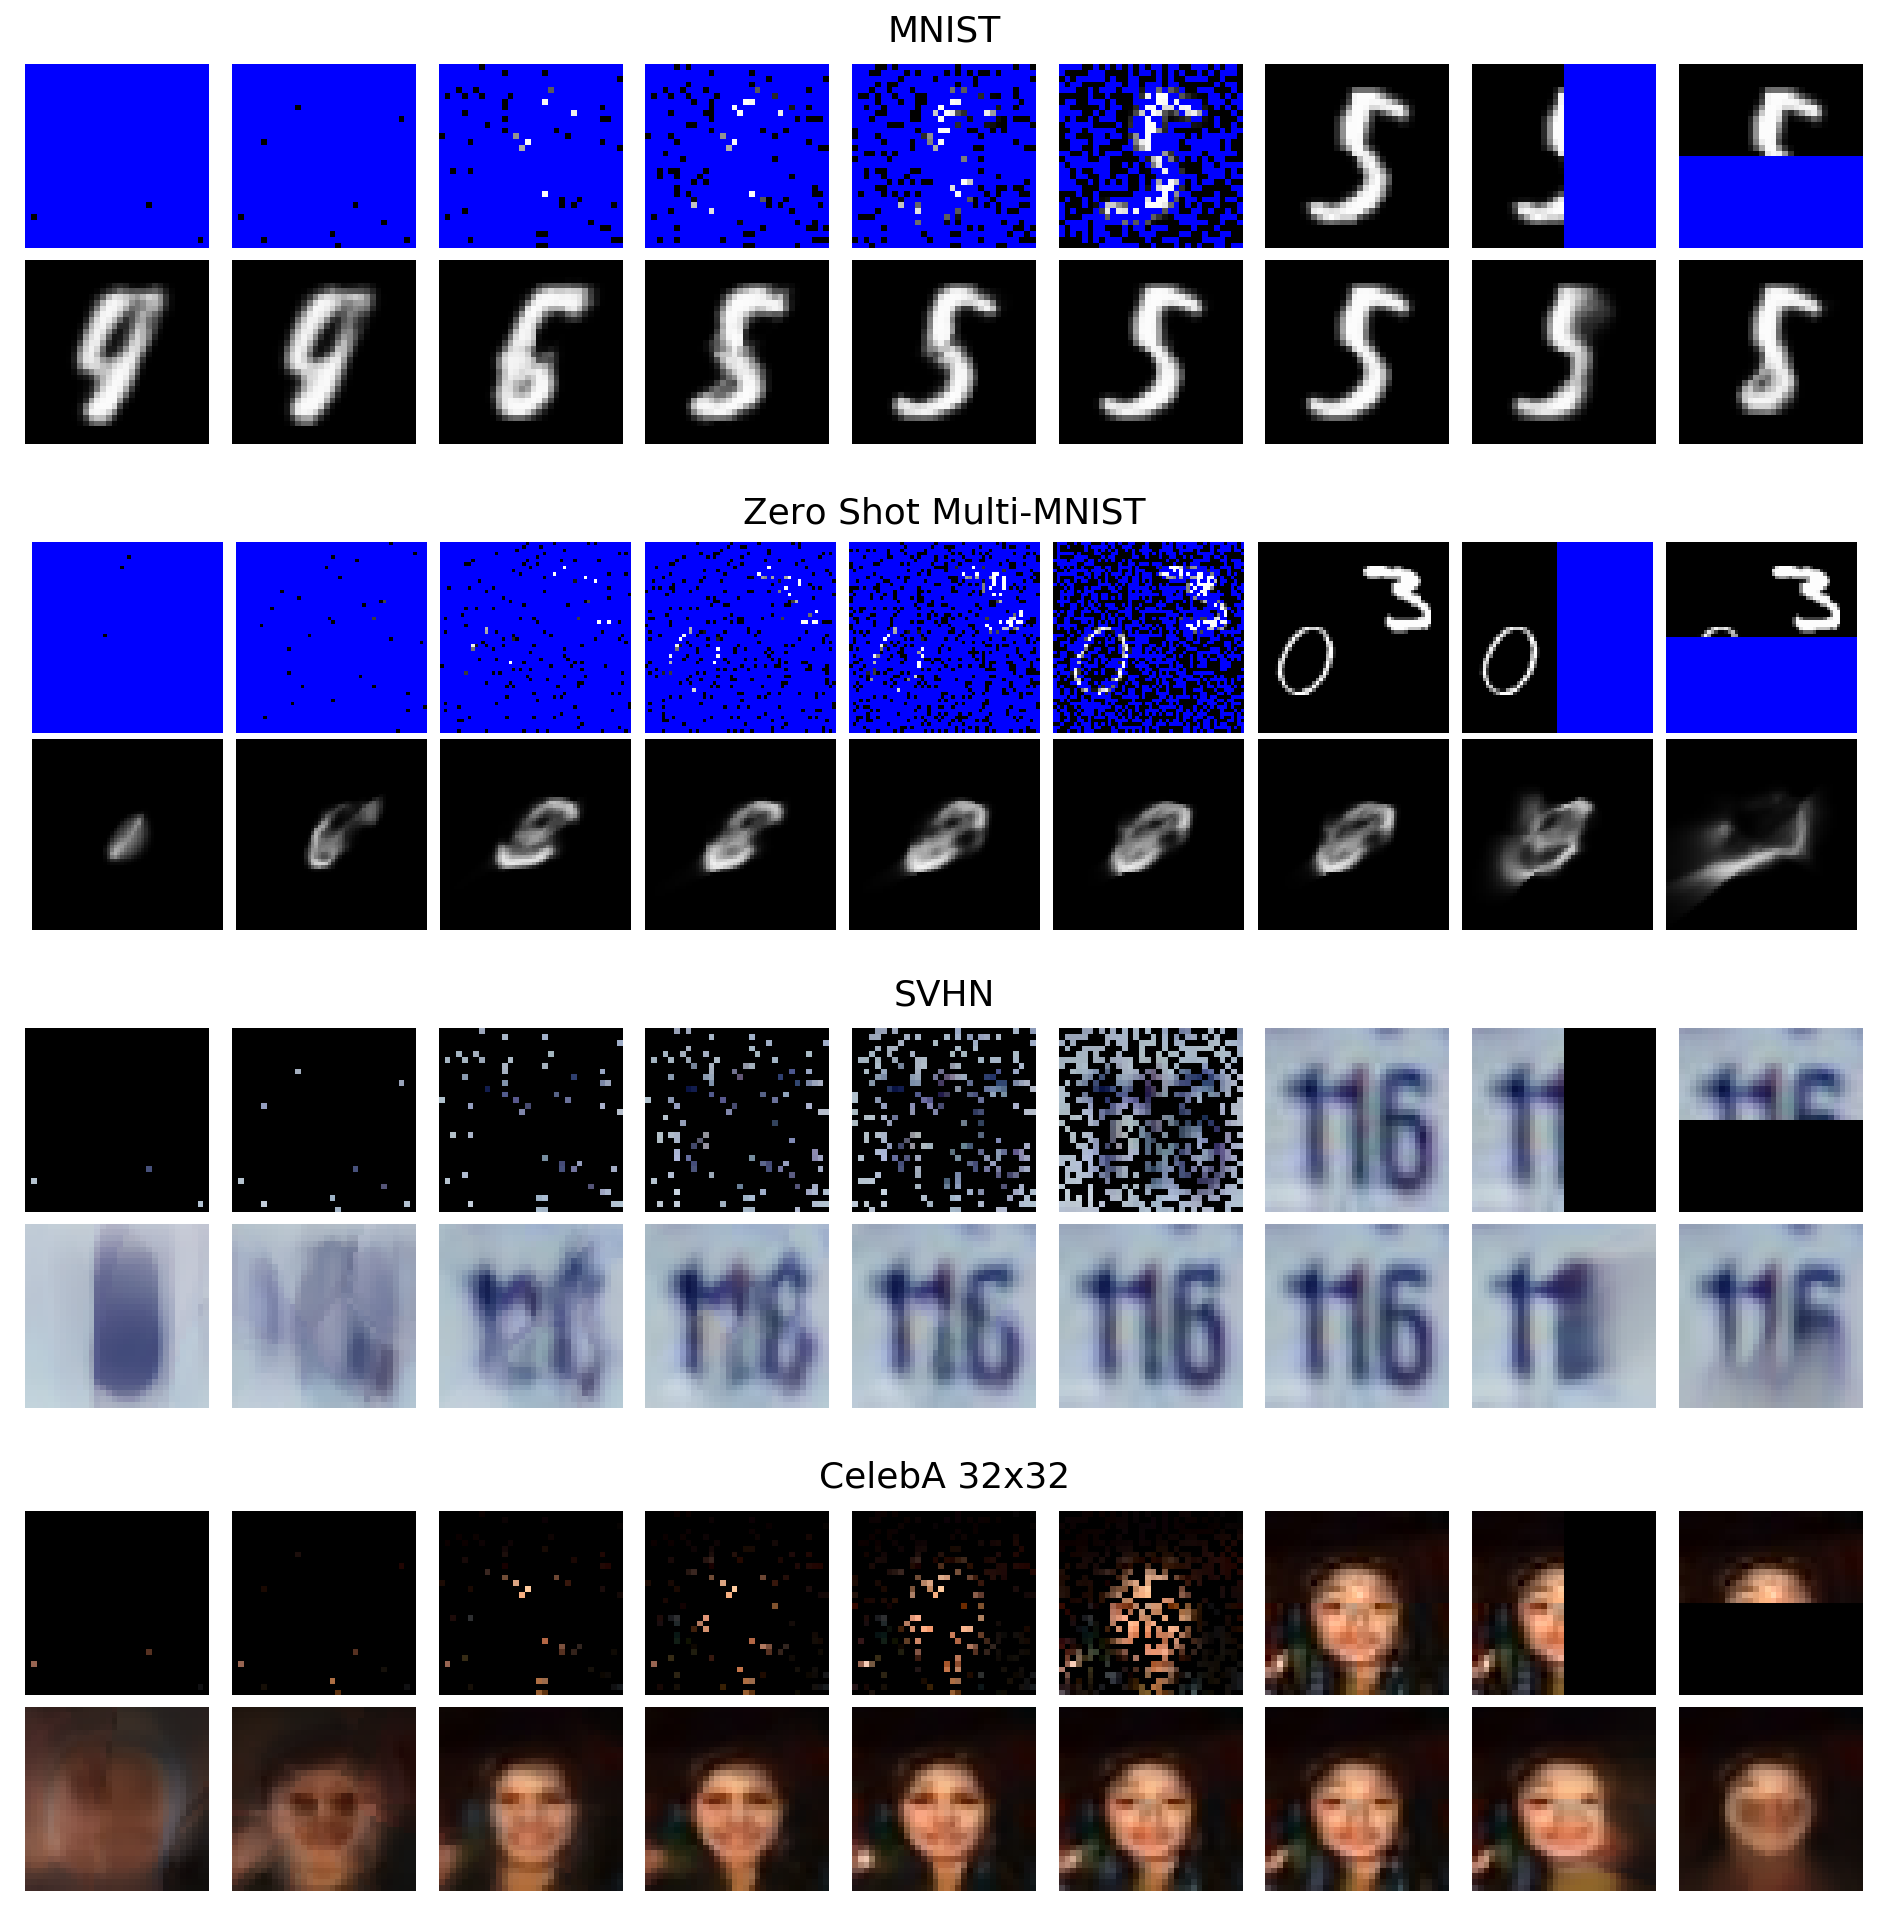

In [37]:
# 3 pixel, 1%, 5%, 10%, 20%, 30%, 50%, 100%, Half Bottom, Half Right
# Rows "mnist", "celeba32", "celeba64", "zs-multi-mnist", "svhn"
# use small model for "zs-multi-mnist"

context_maskers = [RandomMasker(min_nnz=3, max_nnz=3),
                   RandomMasker(min_nnz=0.01, max_nnz=0.01),
                   RandomMasker(min_nnz=0.05, max_nnz=0.05),
                   RandomMasker(min_nnz=0.1, max_nnz=0.1),
                   RandomMasker(min_nnz=0.2, max_nnz=0.2),
                   RandomMasker(min_nnz=0.5, max_nnz=0.5),
                   no_masker, # 100%
                   partial(half_masker, dim=1),
                   partial(half_masker, dim=0),
                  ]

data_models = [(mnist_test, "mnist/SelfAttnCNP"),
               (zs_mmnist_test, "zs-multi-mnist/SelfAttnCNP"), # use the translation equivariant one
               (svhn_test, "svhn/SelfAttnCNP"),
               (celeba32_test, "celeba32/SelfAttnCNP")
              ]

fig, axes = plt.subplots(len(data_models), 1, figsize=(31,17))

for i,(data_test, model) in enumerate(data_models):
    
    grid = torch.cat([plot_posterior_img(data_test, 
                                      GridCntxtTrgtGetter(context_masker=c,
                                                         target_masker=no_masker), 
                                      trainers_grided['{}/run_0'.format(model)].module_.cpu(), 
                                      MeanPredictor=VanillaPredictor,
                                      n_plots=1,
                                      is_uniform_grid=False,
                                      is_return=True,
                                      seed=123 +  int("celeba64" in model)) # don't  show same images for celeba32 and celeba64
        for c in context_maskers], dim=2)
    
    axes[i].imshow(grid.permute(1, 2, 0).numpy())
    axes[i].axis("off")
    axes[i].set_title(data_names[model.split("/")[0]], fontsize=18)

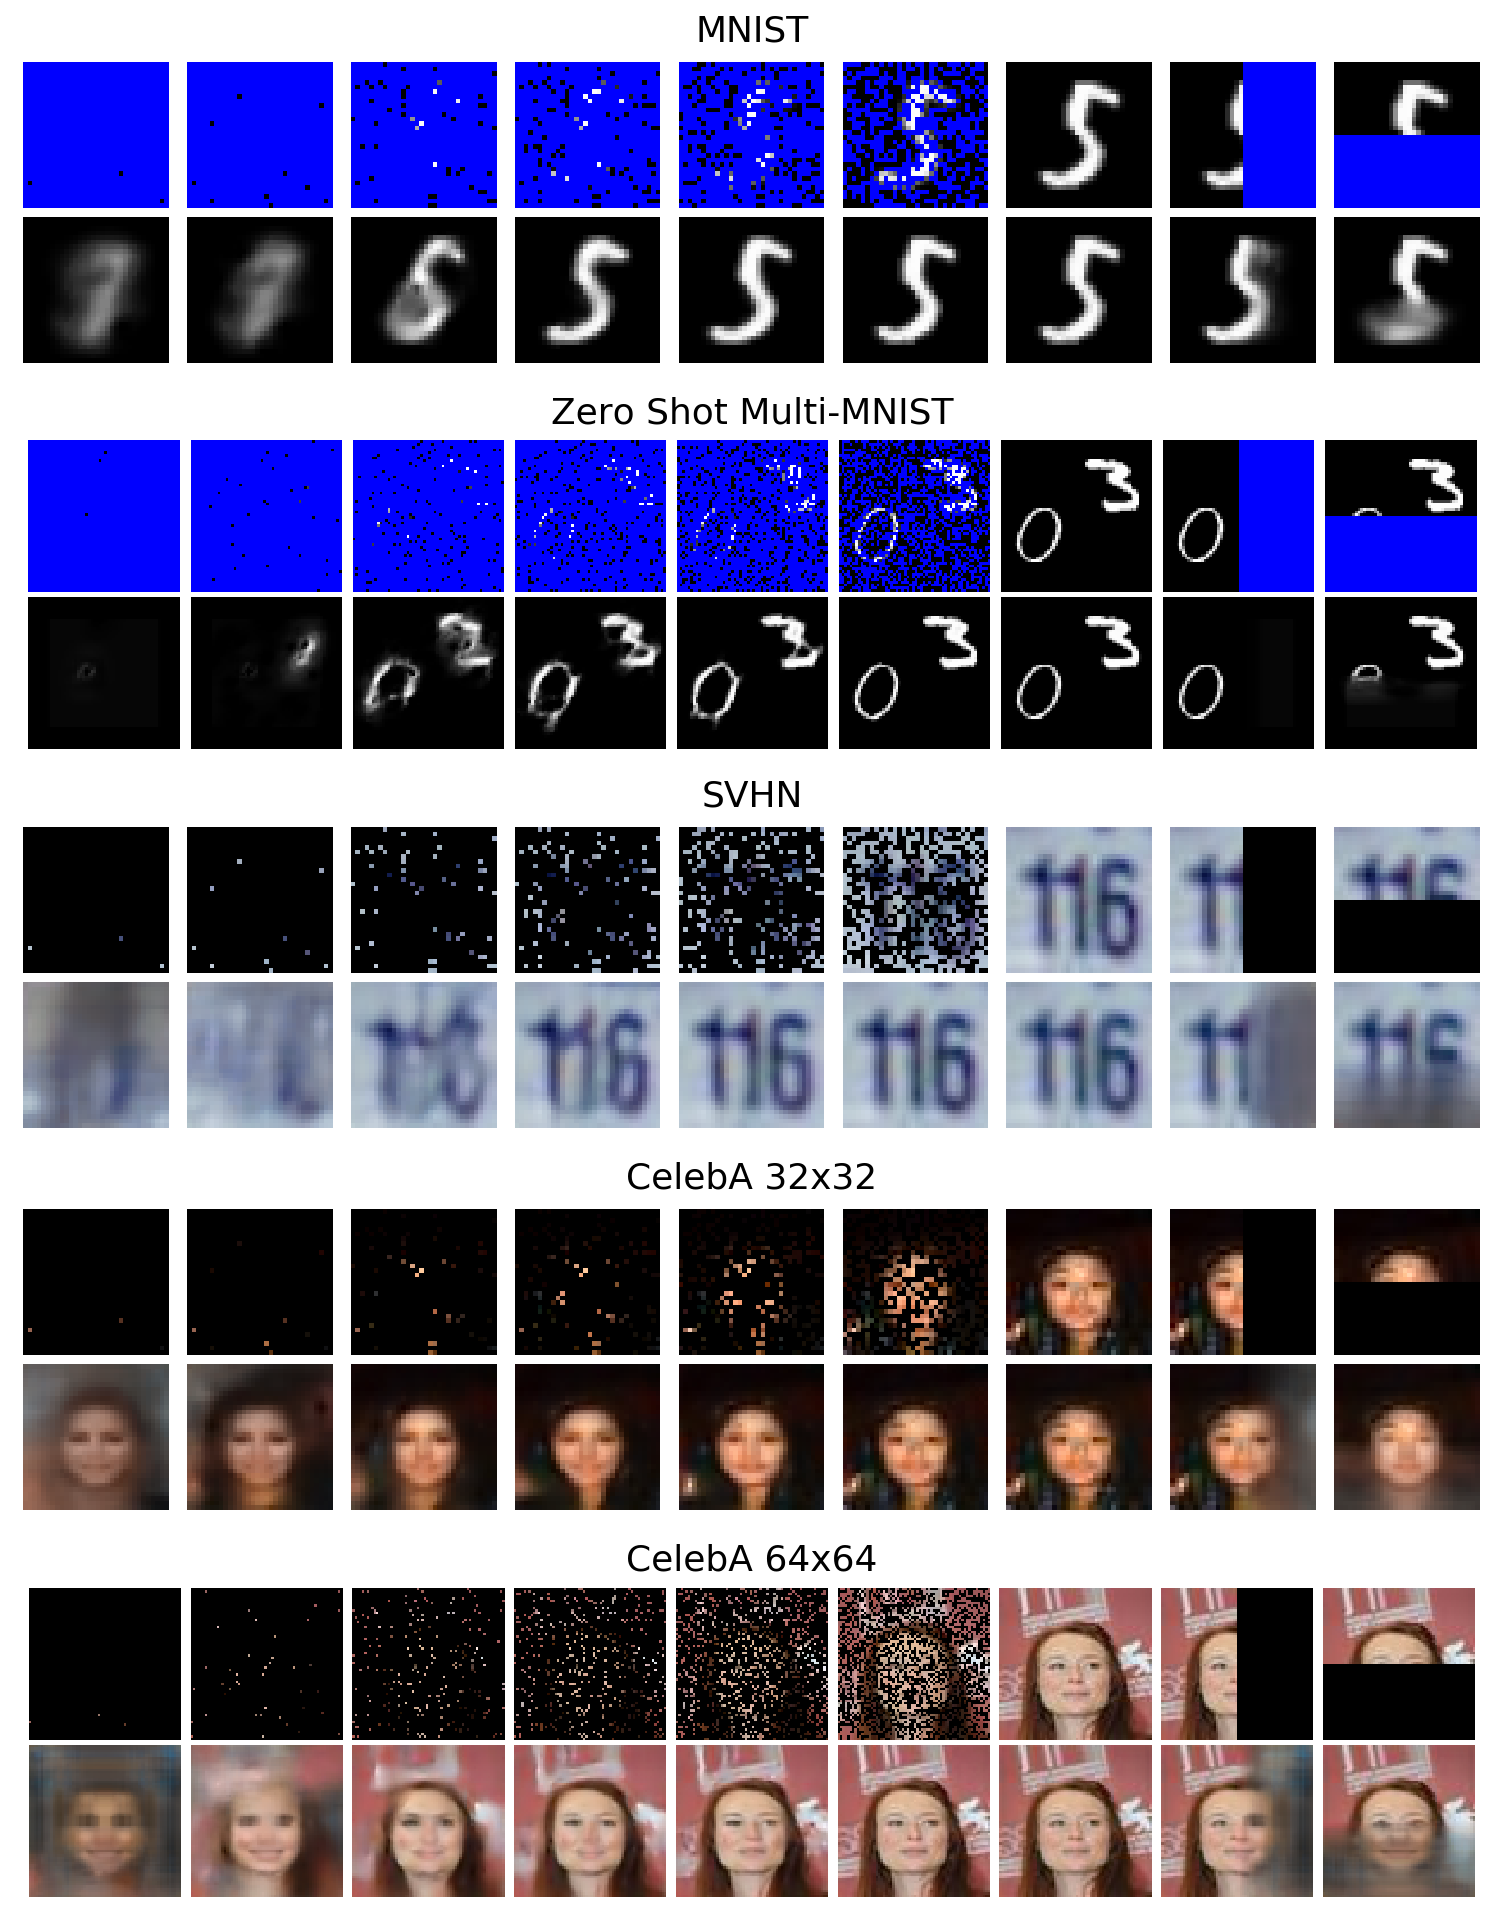

In [38]:
# 3 pixel, 1%, 5%, 10%, 20%, 30%, 50%, 100%, Half Bottom, Half Right
# Rows "mnist", "celeba32", "celeba64", "zs-multi-mnist", "svhn"
# use small model for "zs-multi-mnist"

context_maskers = [RandomMasker(min_nnz=3, max_nnz=3),
                   RandomMasker(min_nnz=0.01, max_nnz=0.01),
                   RandomMasker(min_nnz=0.05, max_nnz=0.05),
                   RandomMasker(min_nnz=0.1, max_nnz=0.1),
                   RandomMasker(min_nnz=0.2, max_nnz=0.2),
                   RandomMasker(min_nnz=0.5, max_nnz=0.5),
                   no_masker, # 100%
                   partial(half_masker, dim=1),
                   partial(half_masker, dim=0),
                  ]

data_models = [(mnist_test, "mnist/GridedCCP_large"),
               (zs_mmnist_test, "zs-multi-mnist/GridedCCP"), # use the translation equivariant one
               (svhn_test, "svhn/GridedCCP_large"),
               (celeba32_test, "celeba32/GridedCCP_large"),
               (celeba64_test, "celeba64/GridedCCP_large")
              ]

fig, axes = plt.subplots(len(data_models), 1, figsize=(31,17))

for i,(data_test, model) in enumerate(data_models):
    grid = torch.cat([plot_posterior_img(data_test, 
                                      GridCntxtTrgtGetter(context_masker=c,
                                                         target_masker=no_masker), 
                                      trainers_grided['{}/run_0'.format(model)].module_.cpu(), 
                                      MeanPredictor=VanillaPredictor,
                                      n_plots=1,
                                      is_uniform_grid=True,
                                      is_return=True,
                                      seed=123 +  int("celeba64" in model)) # don't  show same images for celeba32 and celeba64
        for c in context_maskers], dim=2)
    
    axes[i].imshow(grid.permute(1, 2, 0).numpy())
    axes[i].axis("off")
    axes[i].set_title(data_names[model.split("/")[0]], fontsize=18)

## Understanding the first Layer

First Layer of small GridedCCP


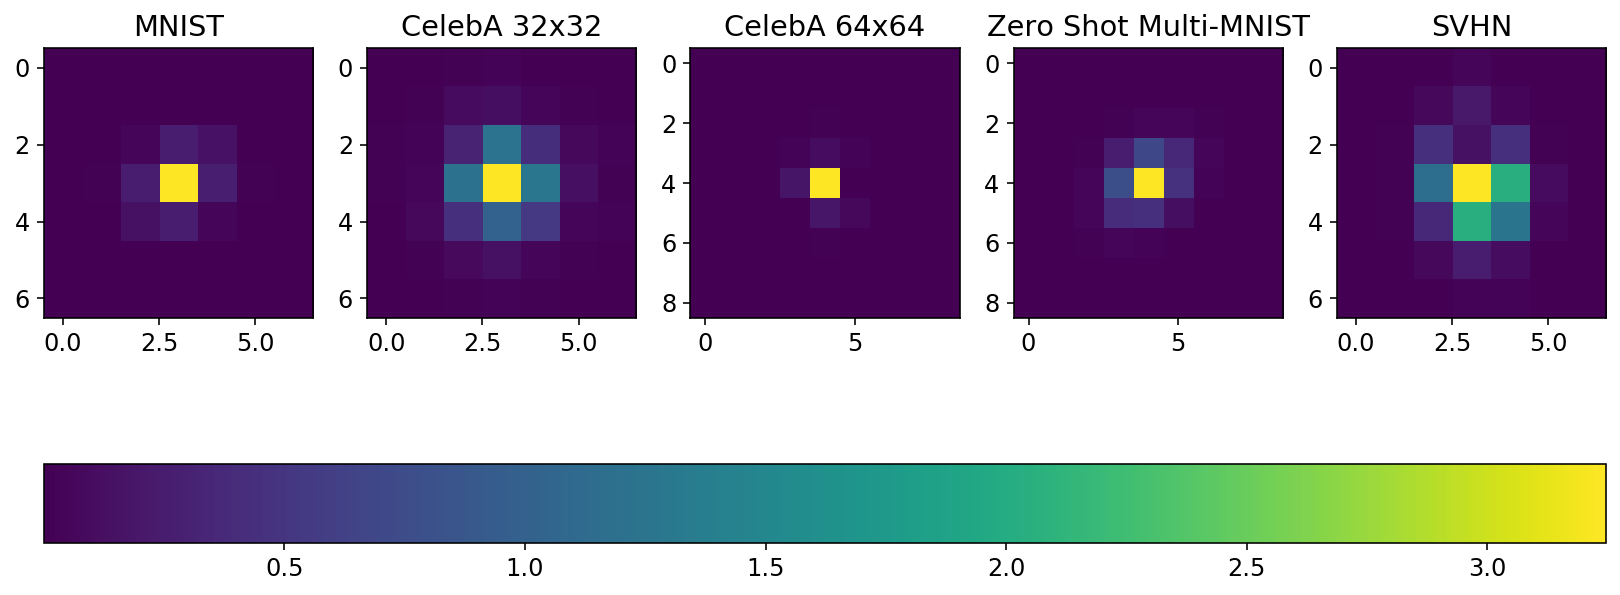

In [39]:


dataset = ["mnist", "celeba32", "celeba64", "zs-multi-mnist", "svhn"]
fig, axes = plt.subplots(1,len(dataset), figsize=(14,9))

for i, d in enumerate(dataset):
    # use abs because I force positive weights in my implementation
    weights_layer_1 = trainers_grided['{}/GridedCCP/run_0'.format(d)].module_.conv.weight.squeeze(1).mean(0).abs()
    im = axes[i].imshow(weights_layer_1.detach().numpy())
    axes[i].set_title(data_names[d])
    
fig.colorbar(im,  orientation="horizontal", ax=axes.ravel().tolist())
print("First Layer of small GridedCCP")

First Layer of large GridedCCP


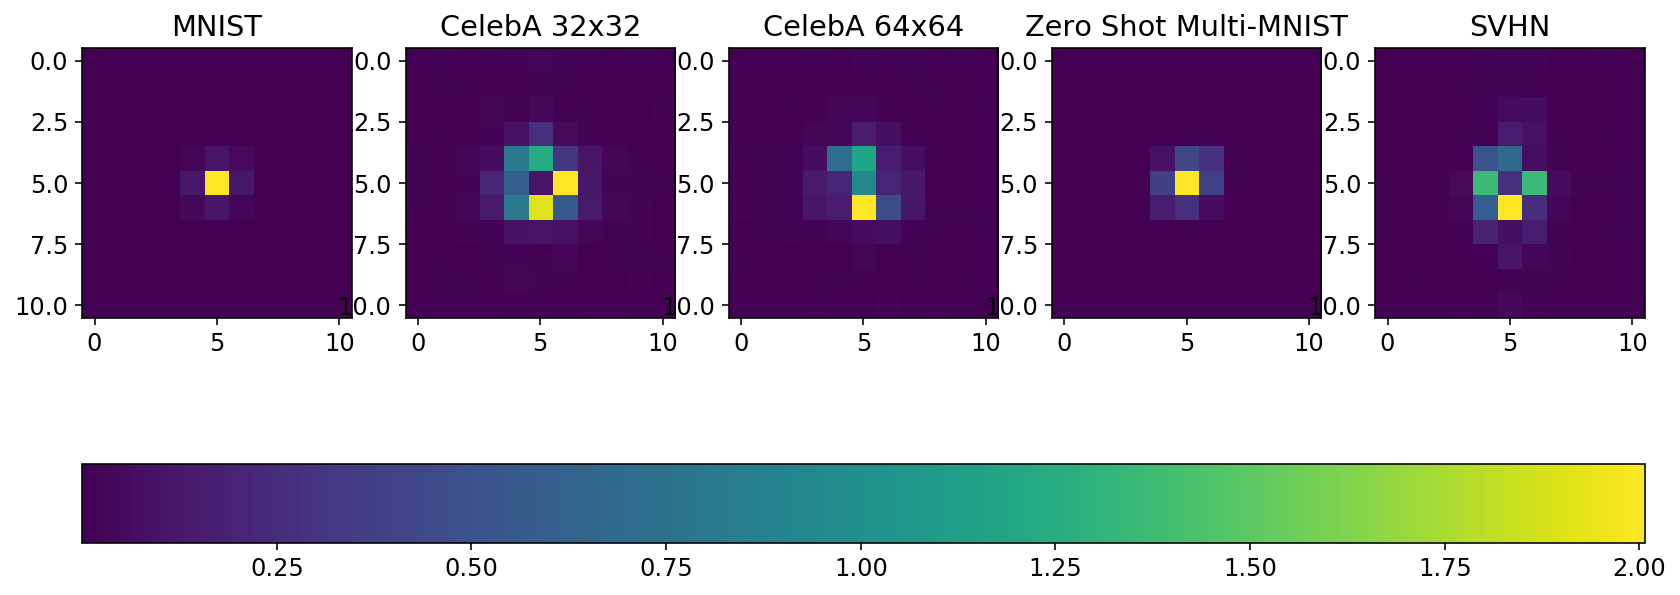

In [40]:
trainers_grided = merge_dicts([trainers_grided_64, trainers_grided_32, trainers_general])

dataset = ["mnist", "celeba32", "celeba64", "zs-multi-mnist", "svhn"]
fig, axes = plt.subplots(1,len(dataset), figsize=(14,9))

for i, d in enumerate(dataset):
    # use abs because I force positive weights in my implementation
    weights_layer_1 = trainers_grided['{}/GridedCCP_large/run_0'.format(d)].module_.conv.weight.squeeze(1).mean(0).abs()
    im = axes[i].imshow(weights_layer_1.detach().numpy())
    axes[i].set_title(data_names[d])
    
fig.colorbar(im,  orientation="horizontal", ax=axes.ravel().tolist())
print("First Layer of large GridedCCP")

We see that it when it is not translation equivariant it uses a non RBF like first layer.

## Loosing Translation Equivariance with Large Receptive Field

When using a large receptuve field in our datasets, the mdoel is able to learn to not be translation equivariant.

In [41]:
context_maskers = [RandomMasker(min_nnz=3, max_nnz=3),
                   RandomMasker(min_nnz=0.01, max_nnz=0.01),
                   RandomMasker(min_nnz=0.05, max_nnz=0.05),
                   RandomMasker(min_nnz=0.1, max_nnz=0.1),
                   RandomMasker(min_nnz=0.2, max_nnz=0.2),
                   RandomMasker(min_nnz=0.5, max_nnz=0.5),
                   no_masker, # 100%
                   partial(half_masker, dim=1),
                   partial(half_masker, dim=0),
                  ]

data_models = [(mnist_test, "mnist/GridedCCP"),
               (zs_mmnist_test, "zs-multi-mnist/GridedCCP"), # use the translation equivariant one
               (svhn_test, "svhn/GridedCCP"),
               (celeba32_test, "celeba32/GridedCCP"),
               (celeba64_test, "celeba64/GridedCCP")
              ]



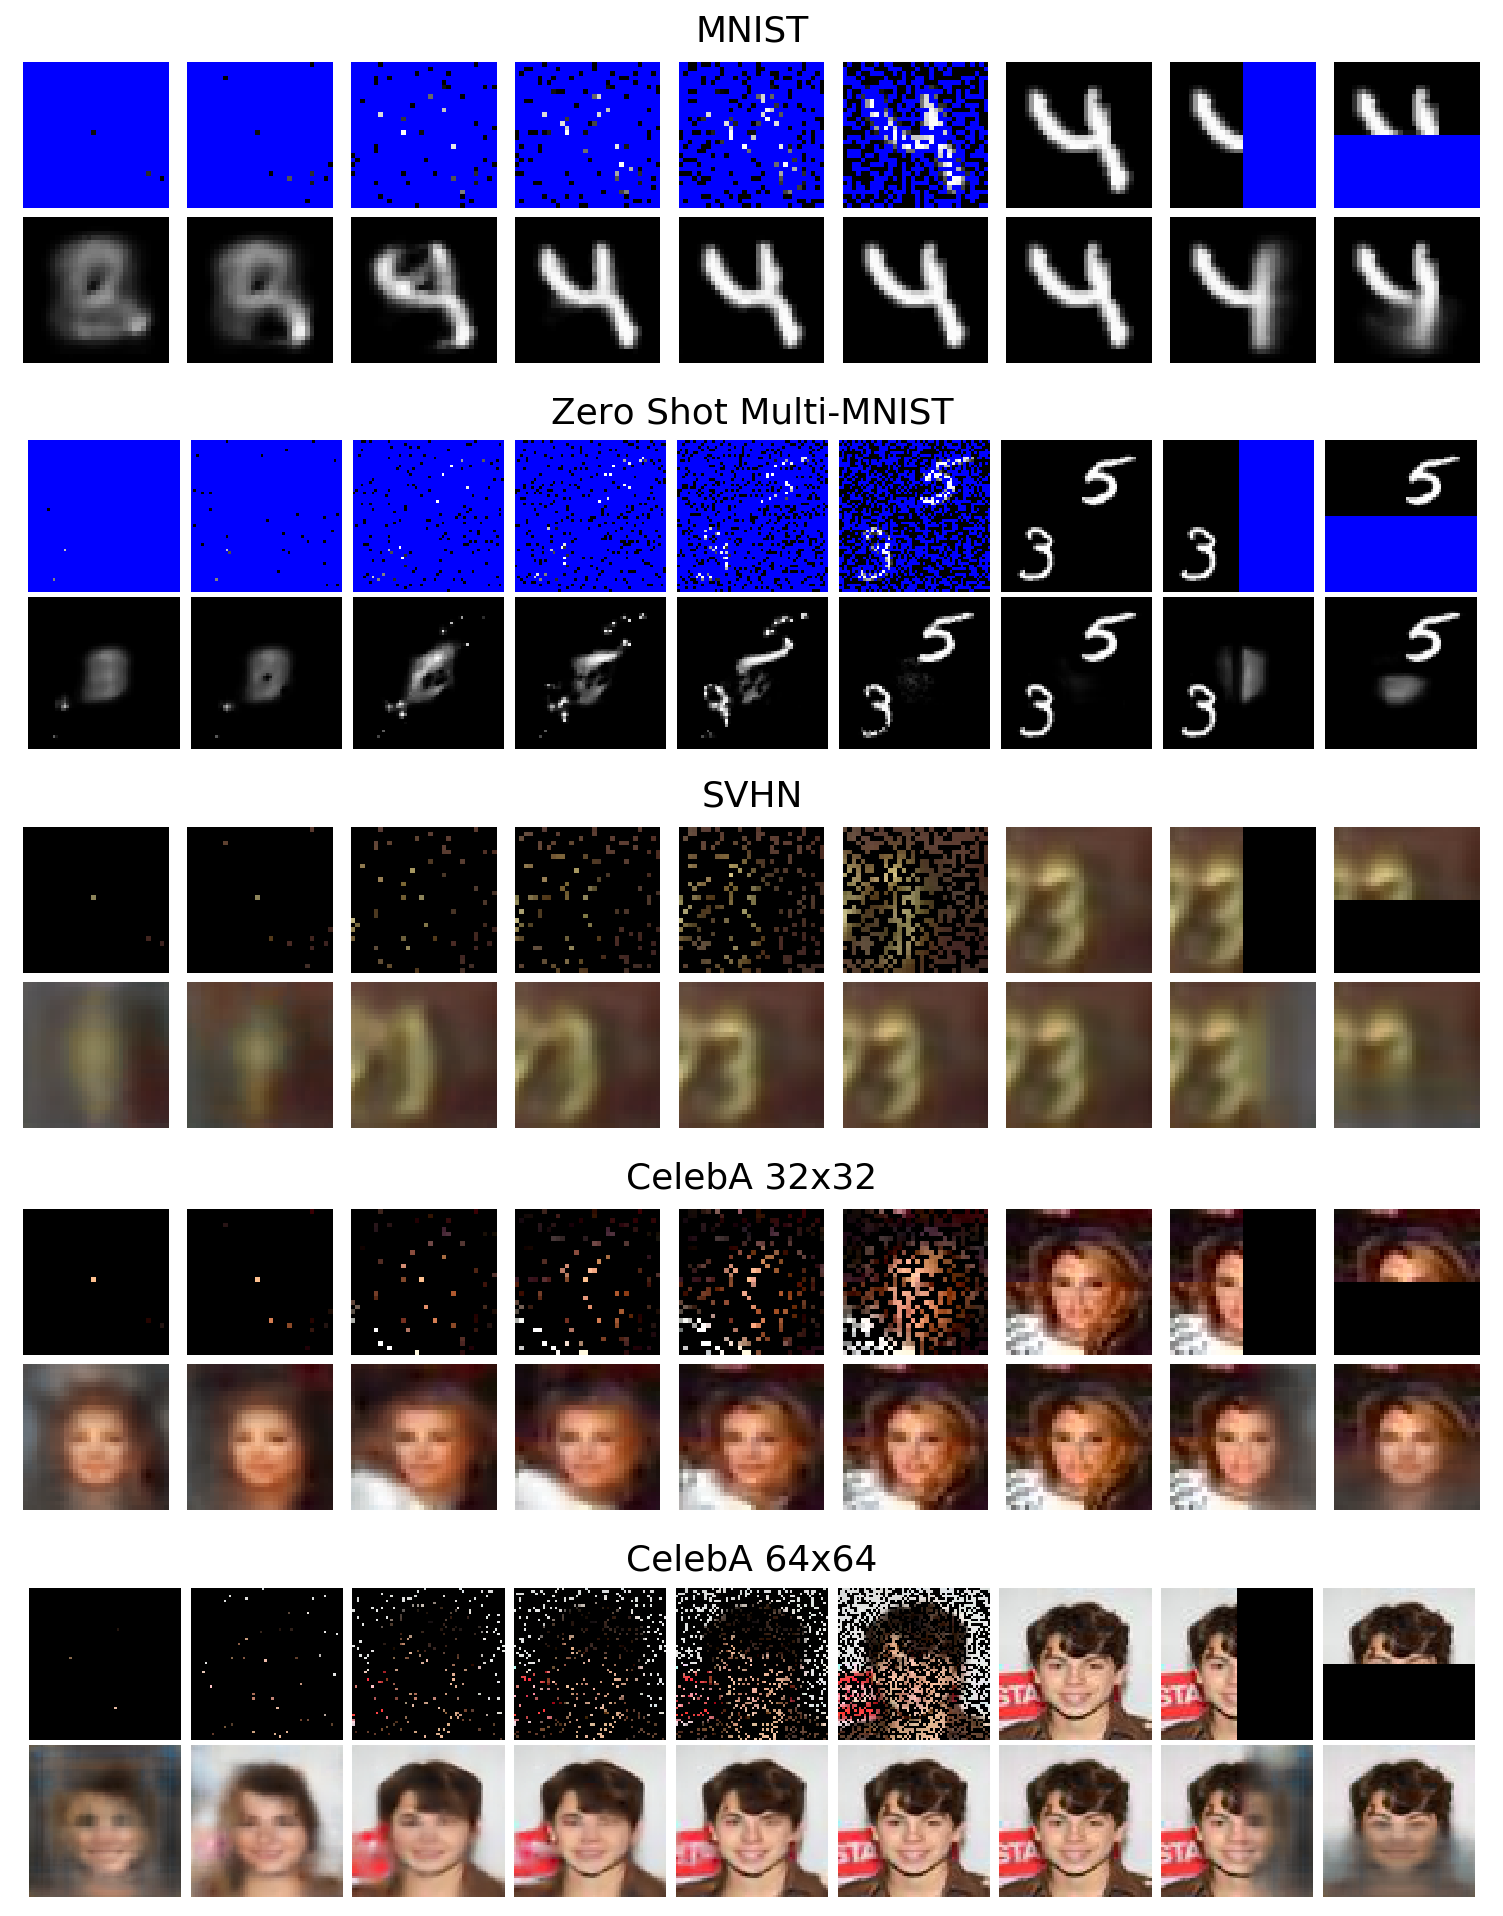

In [42]:
# Large Model

fig, axes = plt.subplots(len(data_models), 1, figsize=(31,17))

for i,(data_test, model) in enumerate(data_models):
    grid = torch.cat([plot_posterior_img(data_test, 
                                      GridCntxtTrgtGetter(context_masker=c,
                                                         target_masker=no_masker), 
                                      trainers_grided['{}_large/run_0'.format(model)].module_.cpu(), 
                                      MeanPredictor=VanillaPredictor,
                                      n_plots=1,
                                      is_uniform_grid=True,
                                      is_return=True,
                                      seed=1 +  int("celeba64" in model)) # don't  show same images for celeba32 and celeba64
        for c in context_maskers], dim=2)
    
    axes[i].imshow(grid.permute(1, 2, 0).numpy())
    axes[i].axis("off")
    axes[i].set_title(data_names[model.split("/")[0]], fontsize=18)




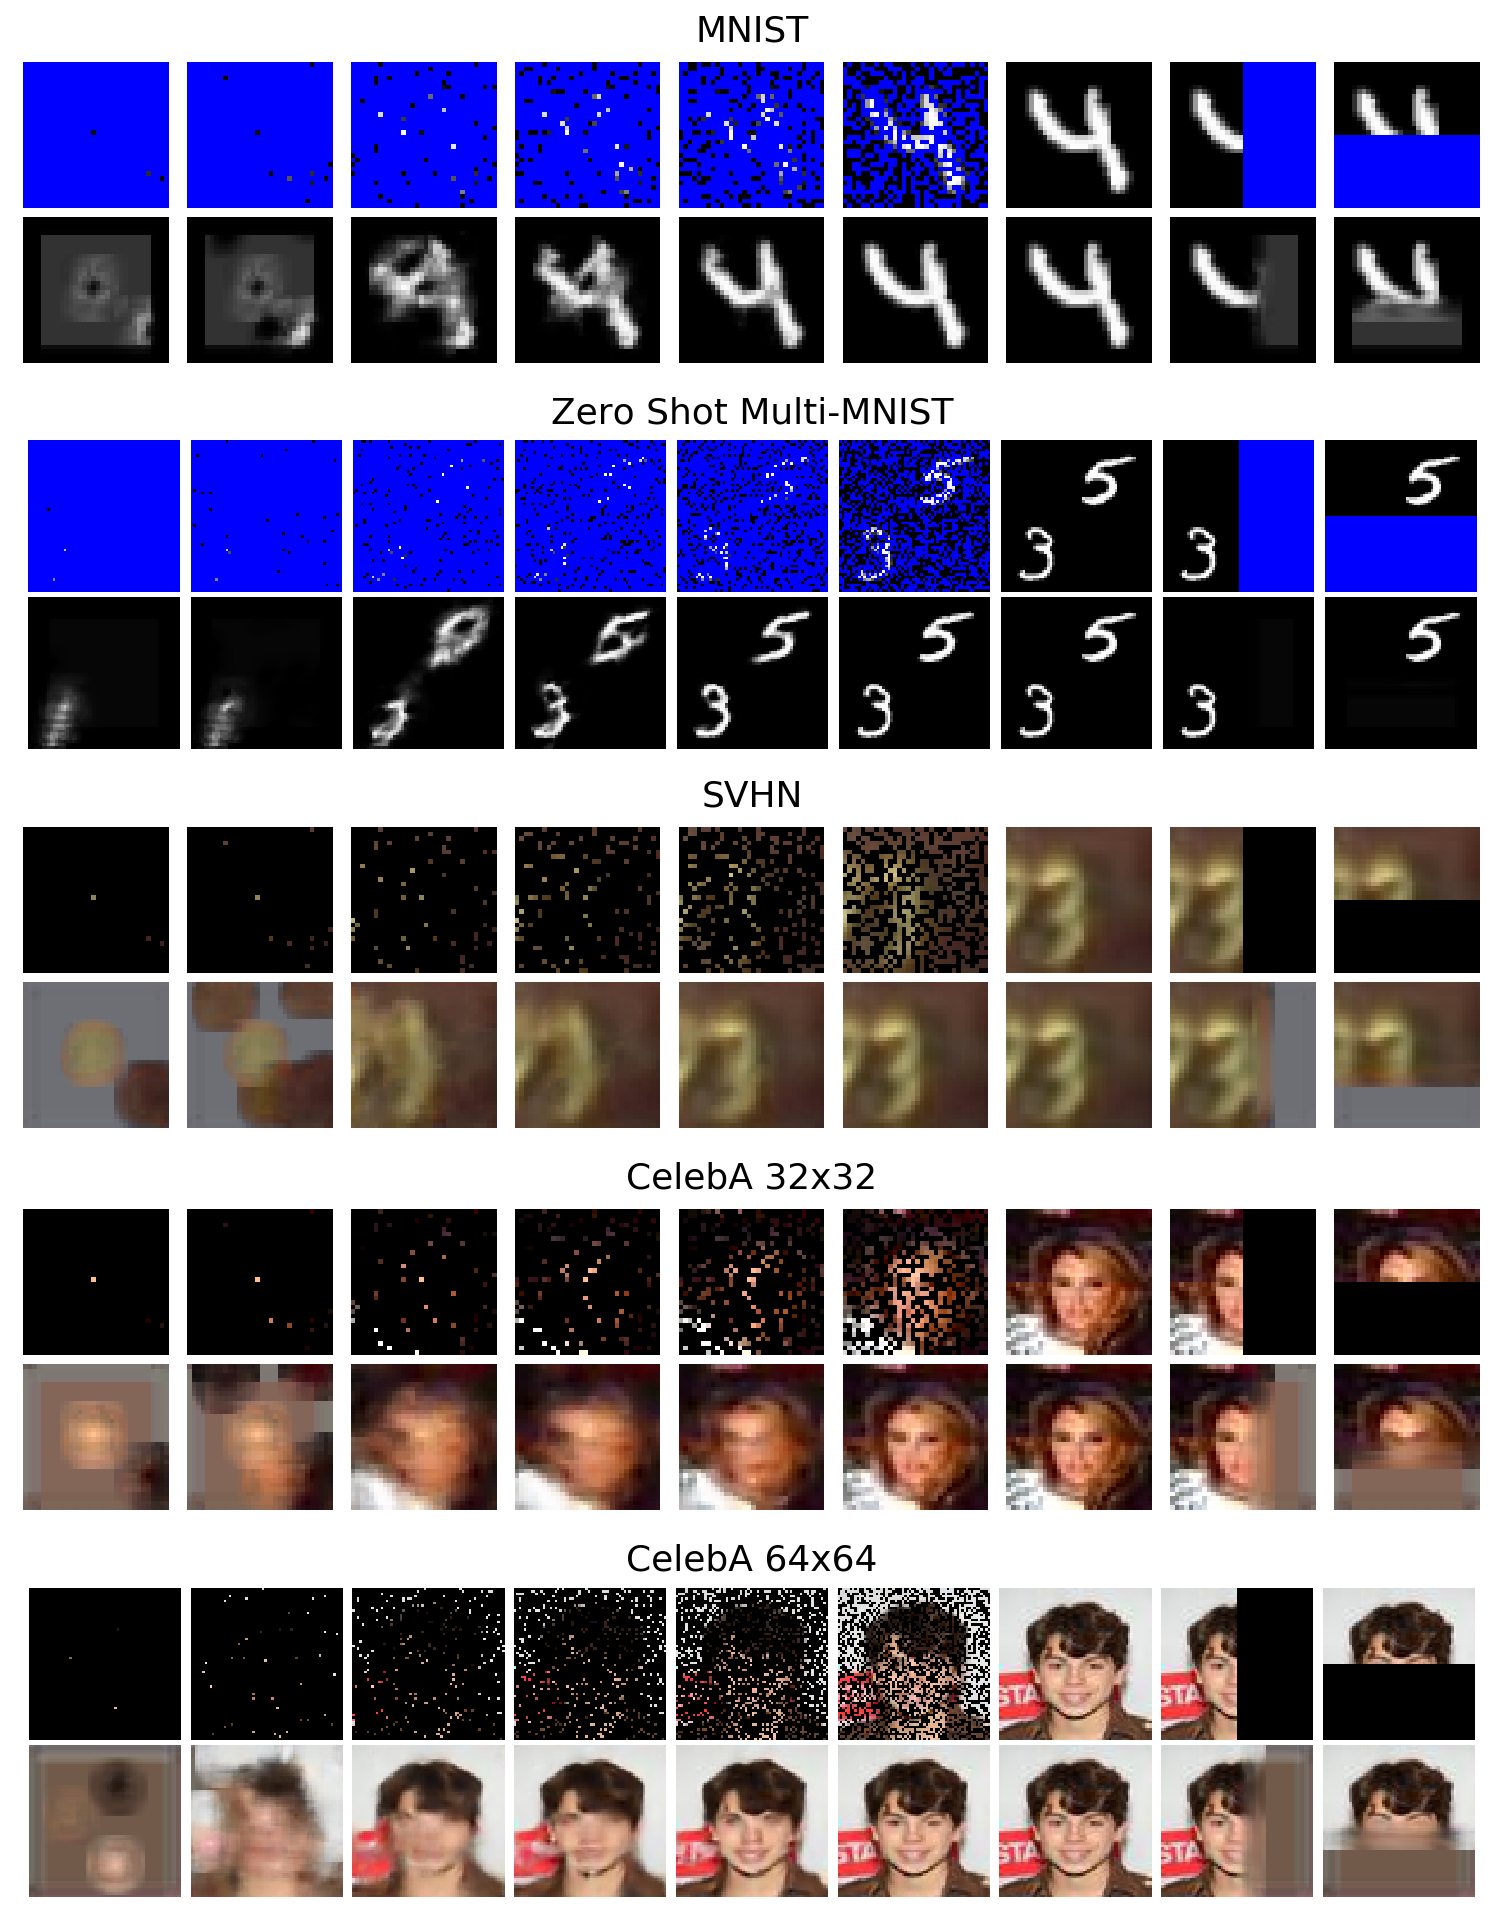

In [43]:
# Small Model

fig, axes = plt.subplots(len(data_models), 1, figsize=(31,17))

for i,(data_test, model) in enumerate(data_models):
    grid = torch.cat([plot_posterior_img(data_test, 
                                      GridCntxtTrgtGetter(context_masker=c,
                                                         target_masker=no_masker), 
                                      trainers_grided['{}/run_0'.format(model)].module_.cpu(), 
                                      MeanPredictor=VanillaPredictor,
                                      n_plots=1,
                                      is_uniform_grid=True,
                                      is_return=True,
                                      seed=1 +  int("celeba64" in model)) # don't  show same images for celeba32 and celeba64
        for c in context_maskers], dim=2)
    
    axes[i].imshow(grid.permute(1, 2, 0).numpy())
    axes[i].axis("off")
    axes[i].set_title(data_names[model.split("/")[0]], fontsize=18)

We see that it loses translation equivariance

## Will Not Mention But Interesting
- Autoregressive is hard to make work for colored images because it gets one channel off by a little and then diverges. I.e. variance is too high even if expectation might be good.
- Training with autoregressive helps a little but not much (+ the results are bad when not testing with AR)
- Training with autoregressive where the mask used is a learned function inversely proportional to the predicted variance works best, but still the results are not much better than in the non AR.


Autoregessive examples:

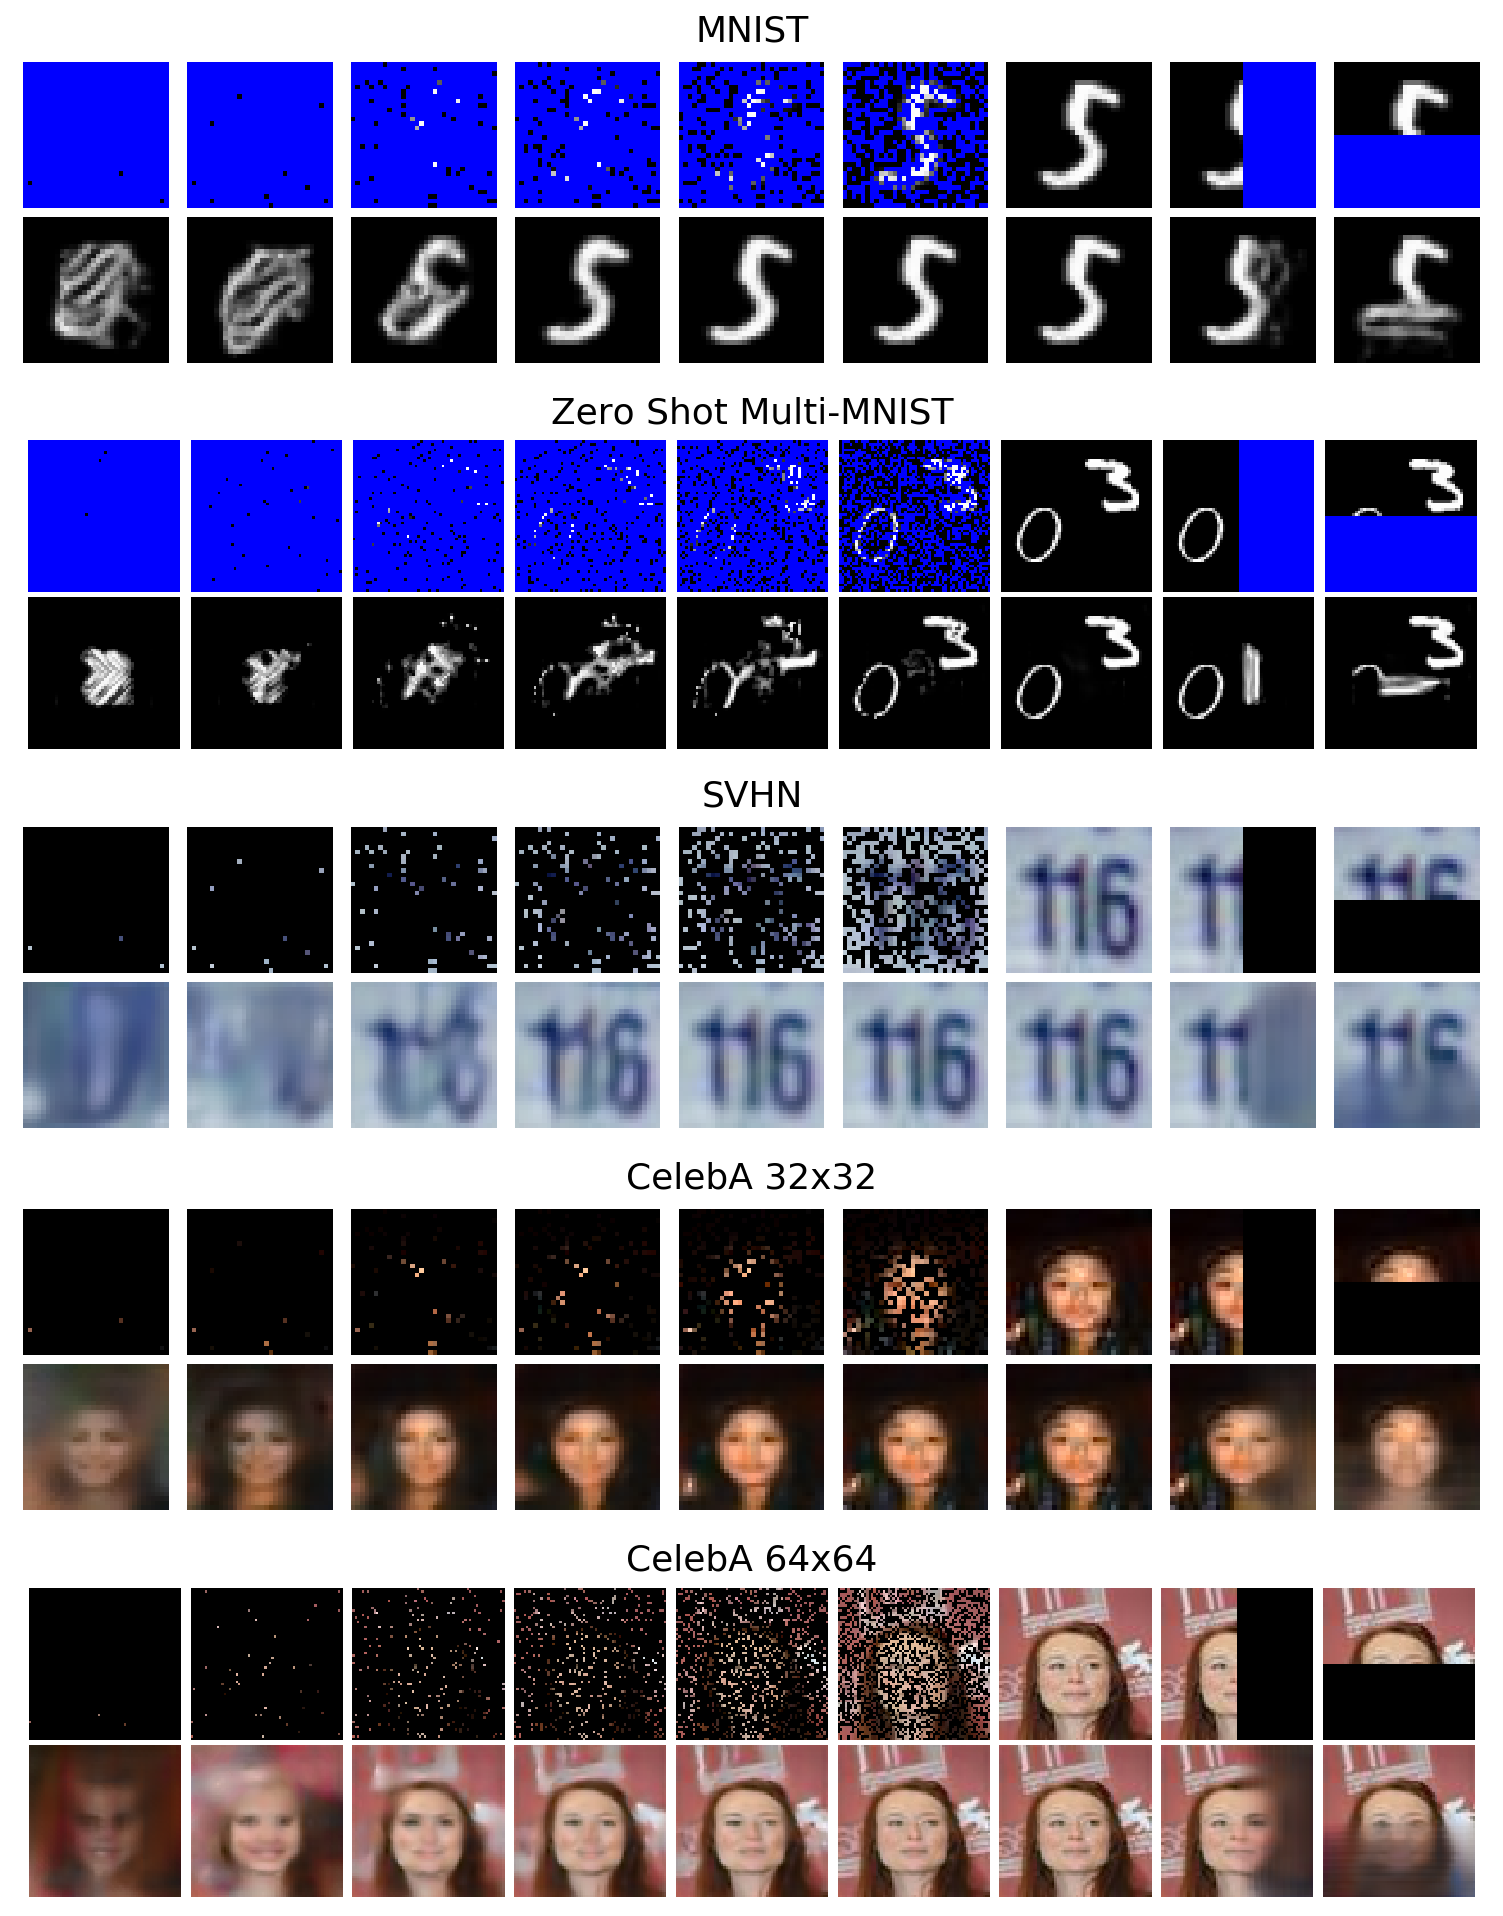

In [44]:
from neuralproc.utils.predict import AutoregressivePredictor, VanillaPredictor, GenNextAutoregressivePixelL1

# Large Model

fig, axes = plt.subplots(len(data_models), 1, figsize=(31,17))

for i,(data_test, model) in enumerate(data_models):
    grid = torch.cat([plot_posterior_img(data_test, 
                                      GridCntxtTrgtGetter(context_masker=c,
                                                         target_masker=no_masker), 
                                      trainers_grided['{}_large/run_0'.format(model)].module_.cpu(), 
                                      MeanPredictor=partial(AutoregressivePredictor,
                                                            gen_autoregressive_trgts=GenNextAutoregressivePixelL1(3)),
                                      n_plots=1,
                                      is_uniform_grid=True,
                                      is_return=True,
                                      seed=123 +  int("celeba64" in model)) # don't  show same images for celeba32 and celeba64
        for c in context_maskers], dim=2)
    
    axes[i].imshow(grid.permute(1, 2, 0).numpy())
    axes[i].axis("off")
    axes[i].set_title(data_names[model.split("/")[0]], fontsize=18)





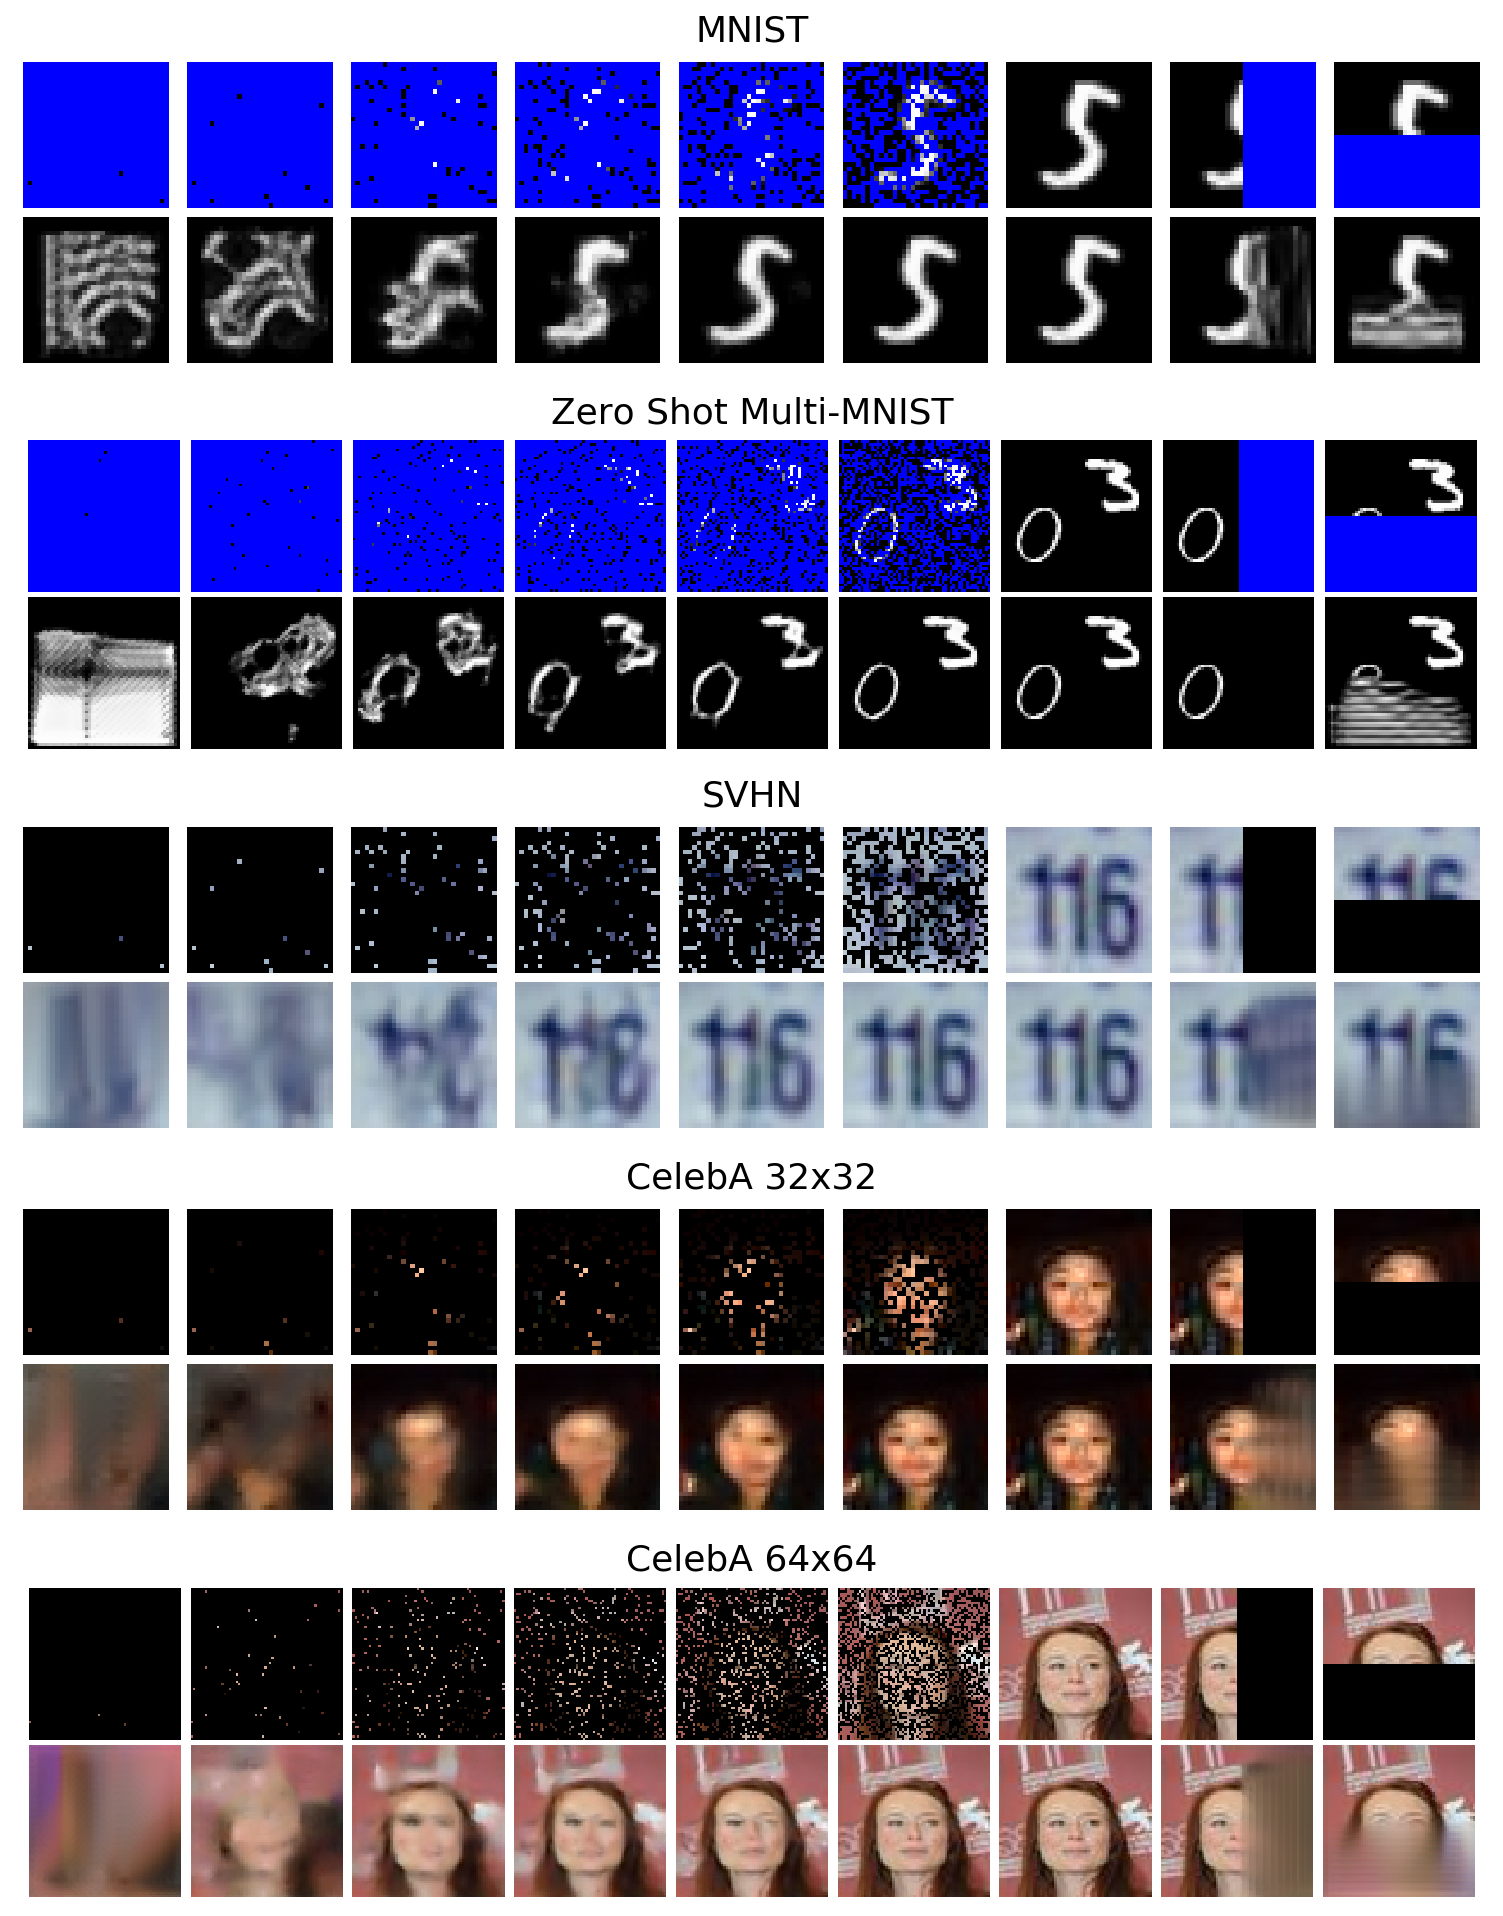

In [45]:
from neuralproc.utils.predict import AutoregressivePredictor, VanillaPredictor, GenNextAutoregressivePixelL1

# Large Model

fig, axes = plt.subplots(len(data_models), 1, figsize=(31,17))

for i,(data_test, model) in enumerate(data_models):
    grid = torch.cat([plot_posterior_img(data_test, 
                                      GridCntxtTrgtGetter(context_masker=c,
                                                         target_masker=no_masker), 
                                      trainers_grided['{}/run_0'.format(model)].module_.cpu(), 
                                      MeanPredictor=partial(AutoregressivePredictor,
                                                            gen_autoregressive_trgts=GenNextAutoregressivePixelL1(3)),
                                      n_plots=1,
                                      is_uniform_grid=True,
                                      is_return=True,
                                      seed=123 +  int("celeba64" in model)) # don't  show same images for celeba32 and celeba64
        for c in context_maskers], dim=2)
    
    axes[i].imshow(grid.permute(1, 2, 0).numpy())
    axes[i].axis("off")
    axes[i].set_title(data_names[model.split("/")[0]], fontsize=18)




